# High Value Customer Identification

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )


## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras ) 
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra
        #
        - Custo:
            - Baixo número de devoluções
        #
        - Experiência:  
            - Média alta de avaliações

#
2. Quantos clientes farão parte do grupo?

    - Número de clientes
    - % em relação ao total de clientes

#
3. Quais as principais características desses clientes?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
    #
    - Escrever os principais comportamentos de compra dos clientes ( métricas de negócio )
        - Vide acima

#
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.

#
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )

#
6. Quais as condições para uma pessoa ser elegível ao Insiders ?

    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders.

#
7. Quais as condições para uma pessoa ser removida do Insiders ?

    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.

#
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

    - Teste de Hipóteses
    - Teste A/B

#
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pickle
import warnings
import regex    as re
import numpy    as np
import pandas   as pd
import seaborn  as sns

import scipy.stats                              as st
from operator            import attrgetter
from tabulate            import tabulate
from plotly              import express         as px
from matplotlib          import pyplot          as plt
from matplotlib          import cm
from IPython.display     import Image
from matplotlib.gridspec import GridSpec
from pandas_profiling    import ProfileReport

from umap                import umap_         as umap
from sklearn             import ensemble      as en
from sklearn             import decomposition as dd
from sklearn.manifold    import TSNE

from hdbscan             import HDBSCAN
from sklearn.neighbors   import NearestNeighbors
from sklearn             import metrics       as m
from sklearn             import mixture       as mx
from sklearn             import cluster       as c
from sklearn             import preprocessing as pp
from sklearn_extra       import cluster       as cme
from scipy.cluster       import hierarchy     as hc
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Fine tunning - Space
from skopt               import gp_minimize
from skopt.space         import Real, Integer
from skopt.utils         import use_named_args
from skopt.callbacks     import CheckpointSaver

## 0.1 Helper Functions

In [2]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignore future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()


def plot_silhouette(X, clusters):
    fig, ax = plt.subplots( 6, 2 )
    fig.set_size_inches( 30, 30 )

    for k in clusters:
        q, mod = divmod( k, 2 )
        
        ax[q-1, mod].set_xlim( [ -0.1, 1] )
        ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
        
        # model definition & training
        hc_model = hc.linkage( X, 'ward' )

        # model predict
        labels = hc.fcluster( hc_model, k, criterion='maxclust' )

        # performance
        ss = m.silhouette_score( X, labels, metric='euclidean' )
        print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

        samples_silhouette_values = m.silhouette_samples( X, labels )

        y_lower = 10
        for i in range( k ):

            # select clusters
            ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
            
            # sort values
            ith_samples_silhouette_values.sort()

            # size clusters
            size_cluster_i = ith_samples_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # colors for each clusters
            cmap = cm.get_cmap( 'Spectral' )
            color = cmap( i / k )

            ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
            
            y_lower = y_upper + 10

        ax[q-1, mod].set_title(f"Silhouette plot for {k} clusters.", fontsize=14,
                               fontweight="bold")
        ax[q-1, mod].set_xlabel("Silhouette Values")
        ax[q-1, mod].set_ylabel("Cluster label") 

        ax[q-1, mod].set_yticks([])
        ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    return None

In [3]:
notebook_settings()

## 0.2 Load Data

In [4]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', low_memory=False, encoding='cp1252')

# 1.0 Descrição dos dados

In [5]:
df1 = data_raw.copy()

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN


## 1.1 Rename Columns

In [6]:
# Drop error column
df1 = df1.drop(columns=['Unnamed: 8'], axis=1)

cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
              'unit_price', 'customer_id', 'country']

df1.columns = cols_news

## 1.2 Data Dimension

In [7]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 541909
number of cols: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [10]:
# Separate df into NA and not NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

# create df for reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())

# create sintetics customers id
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge results of recerence into original df
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1, inplace=True)

In [11]:
# Description column is gonna be droped
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Types

In [12]:
# change invoice_date into date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# change customer_id into int 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.000,80995.000,161990.000,9.552,3.000,218.081,-0.264,119769.160
unit_price,-11062.060,38970.000,50032.060,4.611,2.080,96.760,186.507,59005.719
customer_id,12346.000,22709.000,10363.000,16688.840,16249.000,2911.411,0.487,-0.804


- Valores grandes e negativos em quantity (devoluções?)
- Valores negativos em preço unitário (devolução/promoção?)

### 1.7.2 Categorical Attributes

In [16]:
# Count unique itens per columns
count_ = cat_attributes.apply(lambda x: x.unique().shape).T.rename(columns={0:'count'})
count_

,count
invoice_no,25900
stock_code,4070
description,4224
country,38


In [17]:
# Verify 'invoice no' with caracters
df_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]

print(f'Total numbers of invoices: {len(df1["invoice_no"])}')
print(f'Total numbers of negative invoices: {len(df_invoice)}')
print(f'Total number of negative quantity: {len(df_invoice[df_invoice["quantity"] < 0])}')

# Invoices with positives values
df_invoice[df_invoice['quantity'] >= 0]

Total numbers of invoices: 541909
Total numbers of negative invoices: 9291
Total number of negative quantity: 9288


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.060,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.060,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.060,United Kingdom,21499


In [18]:
# Verify stock code with caracters
df_stock = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]
df_stock_cat = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

print(f'Total numbers of stock code: {len(df1["stock_code"])}')
print(f'Total numbers of stock code with any categorical: {len(df_stock)}')
print(f'Total numbers of stock code with only categorical: {len(df_stock_cat)}')

Total numbers of stock code: 541909
Total numbers of stock code with any categorical: 54873
Total numbers of stock code with only categorical: 2759


In [19]:
# Analysis only codes
df_stock_cat['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [20]:
# Distribuiton for each country
total = cat_attributes['country'].shape[0]
cat_attributes['country'].value_counts().apply(lambda x: 100*(x/total)).head(10)

United Kingdom   91.432
Germany           1.752
France            1.579
EIRE              1.512
Spain             0.467
Netherlands       0.438
Belgium           0.382
Switzerland       0.369
Portugal          0.280
Australia         0.232
Name: country, dtype: float64

# 2.0 Filtragem de variáveis

In [21]:
df2 = df1.copy()

## 2.1 Seleção das colunas

In [22]:
df2.drop(columns='description', axis=1, inplace=True)

## 2.2 Filtragem das linhas

In [23]:
# remove unit_price bellow 0.030 (bellow this consider promo or return)
df2 = df2[df2['unit_price'] > 0.030]

# remove stock code with only categoricals variables (expect DCGSSBOY and DCGSSGIRL)
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 
                                    'm', 'PADS', 'B', 'CRUK', 'BANK CHARGES'])]

# removes information from unidentified countries
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446, 12346])]
df2 = df2[~df2['invoice_no'].isin(['540815', '540818', 'C550456'])] # Customer 15749: duplicates orders

# 3.0 Feature Engineering

In [24]:
df3 = df2.copy()

## 3.1 Feature Engineering

In [25]:
# Time series variables
df3['day'] = df3['invoice_date'].dt.day

df3['month'] = df3['invoice_date'].dt.month

df3['year'] = df3['invoice_date'].dt.year

df3['week_of_year'] = df3['invoice_date'].dt.weekofyear

# separate dataframes for purchases and refunds
df3_purchases = df3[df3['quantity'] >= 0]
df3_returns = df3[df3['quantity'] < 0]

In [26]:
# -------------------- Features based on RFM Model ---------------
# make data frame for reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)


# Gross Revenue (Faturamento) | quantity * price
df3_purchases['gross_revenue'] = df3_purchases['quantity'] * df3_purchases['unit_price']


# Monetary - Total buys from each customer
df_monetary = df3_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
dtype: int64

In [27]:
# Recency - Last day purchase for each customer
df_recency = df3_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace=True)
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
dtype: int64

In [28]:
# Quantity of purchased
df_qnt = (df3_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')
                                             .count().reset_index()
                                             .rename(columns={'invoice_no': 'qty_invoices'}))

df_ref = pd.merge(df_ref, df_qnt, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
dtype: int64

In [29]:
# Quantity of items purchased
df_qnt_items = (df3_purchases[['customer_id', 'quantity']].groupby('customer_id')
                                             .sum().reset_index()
                                             .rename(columns={'quantity': 'qty_items'}))

df_ref = pd.merge(df_ref, df_qnt_items, on='customer_id', how='left')

df_ref.isna().sum()                                             

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
qty_items        67
dtype: int64

In [30]:
# Quantity of products purchased
df_qnt_products = (df3_purchases[['customer_id', 'stock_code']].groupby('customer_id')
                                             .count().reset_index()
                                             .rename(columns={'stock_code': 'qty_products'}))

df_ref = pd.merge(df_ref, df_qnt_products, on='customer_id', how='left')

df_ref.isna().sum()   

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
qty_items        67
qty_products     67
dtype: int64

In [31]:
# Avg ticket - average purchases per customer
df_avg_ticket = df3_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index()
df_avg_ticket.columns = ['customer_id', 'avg_ticket']
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
qty_items        67
qty_products     67
avg_ticket       67
dtype: int64

In [32]:
# Frequency - Frequency of purchases in aprox one year
df_aux = (df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                            .agg(buy_ = ('invoice_no', 'count') ).reset_index())

days = (df3_purchases['invoice_date'].max() - df3_purchases['invoice_date'].min()).days

df_aux['days_'] = days

# Calculate frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
qty_items        67
qty_products     67
avg_ticket       67
frequency        67
dtype: int64

In [33]:
# Number of returns
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

# Merge
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
qty_items        67
qty_products     67
avg_ticket       67
frequency        67
qty_returns       0
dtype: int64

In [34]:
# Ratio of number of returns
df_aux = df_ref[['customer_id', 'qty_items', 'qty_returns']].groupby('customer_id').sum().reset_index()
df_aux['returns_ratio'] = df_aux[['qty_items', 'qty_returns']].apply(lambda x: 0 if x['qty_returns'] <= 0 else 0 if x['qty_items'] <= 0 else x['qty_returns'] / x['qty_items'], axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'returns_ratio']], how='left', on='customer_id')

df_ref = df_ref[df_ref['returns_ratio'] < 1.0] # cleaning customers with ratio above 1.0

df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qty_invoices     67
qty_items        67
qty_products     67
avg_ticket       67
frequency        67
qty_returns       0
returns_ratio     0
dtype: int64

In [35]:
# Basket Size (Quantity)
df_aux = (df3_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                         n_products=('quantity', 'sum')).reset_index())

# calculate basket size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id         0
gross_revenue      67
recency_days       67
qty_invoices       67
qty_items          67
qty_products       67
avg_ticket         67
frequency          67
qty_returns         0
returns_ratio       0
avg_basket_size    67
dtype: int64

In [36]:
# Unique Basket Size
df_aux = (df3_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                         n_products=('stock_code', 'nunique')).reset_index())

# calculate basket size
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id                0
gross_revenue             67
recency_days              67
qty_invoices              67
qty_items                 67
qty_products              67
avg_ticket                67
frequency                 67
qty_returns                0
returns_ratio              0
avg_basket_size           67
avg_unique_basket_size    67
dtype: int64

In [37]:
# Period of buy in each day

df_aux = df3_purchases[['customer_id', 'day', 'invoice_no']].drop_duplicates(subset='invoice_no')
df_aux['period_of_buy_day'] = df_aux.apply(lambda x: 'before_11' if x['day'] <= 10 else 'between_11_20' if x['day'] <= 20 else 'after_20', axis=1)
df_aux = df_aux[['customer_id', 'period_of_buy_day', 'day']].groupby(['customer_id', 'period_of_buy_day']).count().sort_values('day', ascending=False).reset_index().drop_duplicates(subset='customer_id')

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'period_of_buy_day']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id                0
gross_revenue             67
recency_days              67
qty_invoices              67
qty_items                 67
qty_products              67
avg_ticket                67
frequency                 67
qty_returns                0
returns_ratio              0
avg_basket_size           67
avg_unique_basket_size    67
period_of_buy_day         67
dtype: int64

In [38]:
# Period of buy in each quarter

df_aux = df3_purchases[['customer_id', 'month', 'invoice_no']].drop_duplicates(subset='invoice_no')
df_aux['period_of_buy_quarter'] = df_aux.apply(lambda x: 1 if x['month'] <= 3 else 2 if x['month'] <= 6 else 3 if x['month'] <= 9 else 4, axis=1)
df_aux = df_aux[['customer_id', 'period_of_buy_quarter', 'month']].groupby(['customer_id', 'period_of_buy_quarter']).count().sort_values('month', ascending=False).reset_index().drop_duplicates(subset='customer_id')

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'period_of_buy_quarter']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id                0
gross_revenue             67
recency_days              67
qty_invoices              67
qty_items                 67
qty_products              67
avg_ticket                67
frequency                 67
qty_returns                0
returns_ratio              0
avg_basket_size           67
avg_unique_basket_size    67
period_of_buy_day         67
period_of_buy_quarter     67
dtype: int64

In [39]:
# Country
df_aux = df3[['customer_id', 'country']].drop_duplicates(subset='customer_id')

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

df_ref.isna().sum()

customer_id                0
gross_revenue             67
recency_days              67
qty_invoices              67
qty_items                 67
qty_products              67
avg_ticket                67
frequency                 67
qty_returns                0
returns_ratio              0
avg_basket_size           67
avg_unique_basket_size    67
period_of_buy_day         67
period_of_buy_quarter     67
country                    0
dtype: int64

In [40]:
df_ref = df_ref.dropna()

df_ref['period_of_buy_quarter'] = df_ref['period_of_buy_quarter'].astype('int64')

df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
qty_items                 0
qty_products              0
avg_ticket                0
frequency                 0
qty_returns               0
returns_ratio             0
avg_basket_size           0
avg_unique_basket_size    0
period_of_buy_day         0
period_of_buy_quarter     0
country                   0
dtype: int64

# 4.0 Análise exploratória dos dados

In [41]:
df4 = df_ref.copy()

In [42]:
df4.to_csv('../data/interim/df4.csv', index=False)

## 4.1 Análise Univariada

1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range
    - Media, Mediana
    - Desvio padrão e variância
    - Coeficiente de variação (CV)
    - Distribuição

In [43]:
#profile = ProfileReport(df4)
#profile.to_file('../reports/output_v3.html')

### 4.1.1 Gross revenue

In [44]:
df3[df3['customer_id'] == 16446]

# Customer removed

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,day,month,year,week_of_year


### 4.1.2 Quantity of products

In [45]:
df4[df4['qty_products'] == 7838]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,frequency,qty_returns,returns_ratio,avg_basket_size,avg_unique_basket_size,period_of_buy_day,period_of_buy_quarter,country
67,17841,40967.720,1.000,124.000,23053.000,7838.000,5.227,0.332,203.000,0.009,185.911,10.661,before_11,4,United Kingdom


### 4.1.3 Average ticket/ Quantity of returns

In [46]:
df4[df4['avg_ticket'] == 4453.43]

# Customer removed

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,frequency,qty_returns,returns_ratio,avg_basket_size,avg_unique_basket_size,period_of_buy_day,period_of_buy_quarter,country


In [47]:
df3[df3['customer_id'] == 15749]

# Removed duplicate purchases

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,day,month,year,week_of_year
160542,550461,85123A,1930,2017-04-16,2.400,United Kingdom,15749,16,4,2017,15
160543,550461,47556B,1300,2017-04-16,2.100,United Kingdom,15749,16,4,2017,15
160544,550461,48185,670,2017-04-16,6.350,United Kingdom,15749,16,4,2017,15
160545,550461,21175,2000,2017-04-16,1.690,United Kingdom,15749,16,4,2017,15
160546,550461,21108,3114,2017-04-16,2.100,United Kingdom,15749,16,4,2017,15


### 4.1.4 Returns Ratio

In [48]:
df4.sort_values('returns_ratio', ascending=False).head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,frequency,qty_returns,returns_ratio,avg_basket_size,avg_unique_basket_size,period_of_buy_day,period_of_buy_quarter,country
3499,17900,112.200,190.000,2.000,73.000,6.000,18.700,0.005,72.000,0.986,36.500,2.000,after_20,2,United Kingdom
3539,18072,247.440,185.000,1.000,288.000,18.000,13.747,0.003,240.000,0.833,288.000,18.000,before_11,2,United Kingdom
1655,16716,901.200,266.000,2.000,120.000,2.000,450.600,0.005,76.000,0.633,60.000,0.500,between_11_20,1,United Kingdom
1822,14304,383.450,222.000,1.000,139.000,17.000,22.556,0.003,85.000,0.612,139.000,17.000,after_20,2,United Kingdom
574,13984,920.510,26.000,5.000,679.000,16.000,57.532,0.013,408.000,0.601,135.800,2.800,before_11,4,United Kingdom


## 4.2 Análise Bivariada

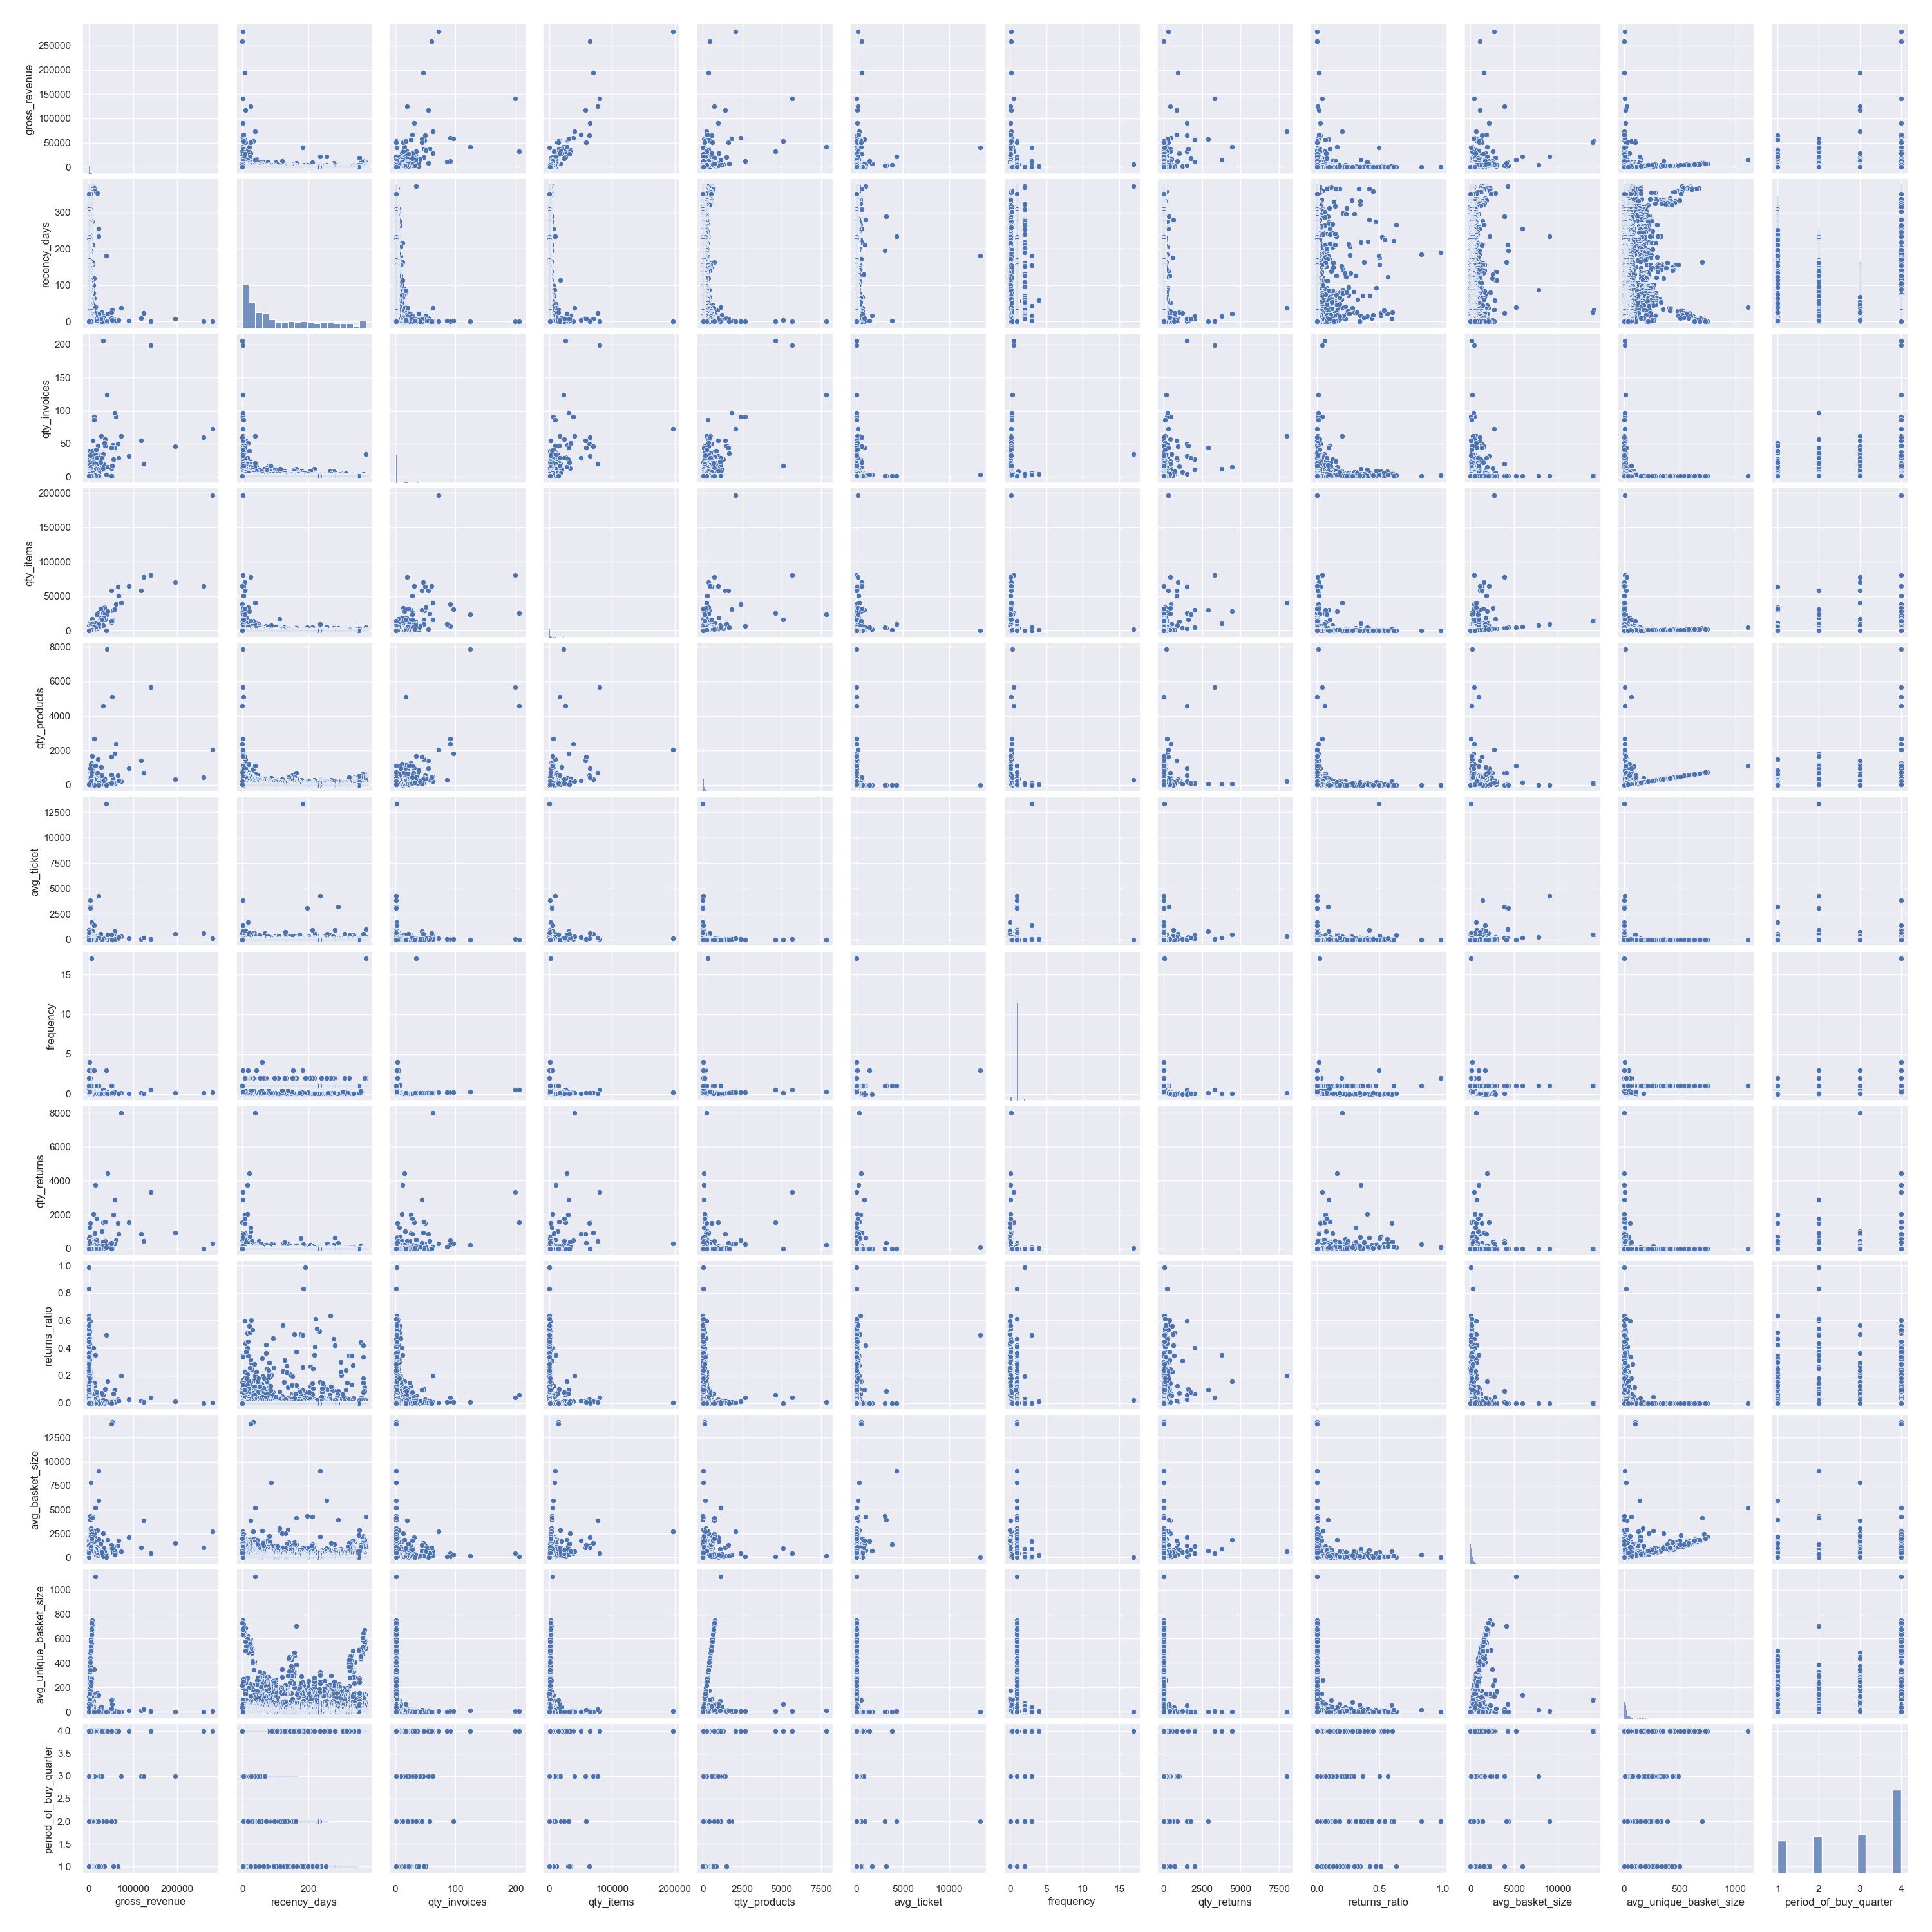

In [49]:
#cols = ['customer_id']
#df42 = df4.drop(cols, axis=1)

#plt.figure(figsize=(25,12))
#sns.pairplot(df42);
#plt.savefig('../reports/pairplot-c4.1_v3.png')

Image('../reports/pairplot-c4.1_v3.png')

- Qty Invoices, Qty Products, Qty Items - Preserve only Qty Invoices
- Frequency has low variancy
- Avg ticket has low variancy

# 5.0 Preparação dos dados

In [50]:
df5 = df4.drop(columns=['customer_id'], axis=1).copy()

In [51]:
# Make rescaling for data organization analysis
mms = pp.MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']].values)
df5['recency_days'] = mms.fit_transform(df5[['recency_days']].values)
df5['qty_invoices'] = mms.fit_transform(df5[['qty_invoices']].values)
df5['qty_items'] = mms.fit_transform(df5[['qty_items']].values)
df5['qty_products'] = mms.fit_transform(df5[['qty_products']].values)
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']].values)
df5['frequency'] = mms.fit_transform(df5[['frequency']].values)
df5['qty_returns'] = mms.fit_transform(df5[['qty_returns']].values)
df5['returns_ratio'] = mms.fit_transform(df5[['returns_ratio']].values)
df5['avg_basket_size'] = mms.fit_transform(df5[['avg_basket_size']].values)
df5['avg_unique_basket_size'] = mms.fit_transform(df5[['avg_unique_basket_size']].values)
df5['period_of_buy_quarter'] = mms.fit_transform(df5[['period_of_buy_quarter']].values)

# Frequency Encoder
fe_period_of_buy_day = df5.groupby('period_of_buy_day').size() / len(df5)
df5.loc[:, 'period_of_buy_day'] = df5['period_of_buy_day'].map(fe_period_of_buy_day)

fe_country = df5.groupby('country').size() / len(df5)
df5.loc[:, 'country'] = df5['country'].map(fe_country)

# 6.0 Estudo do espaço

In [52]:
X = df5.copy()

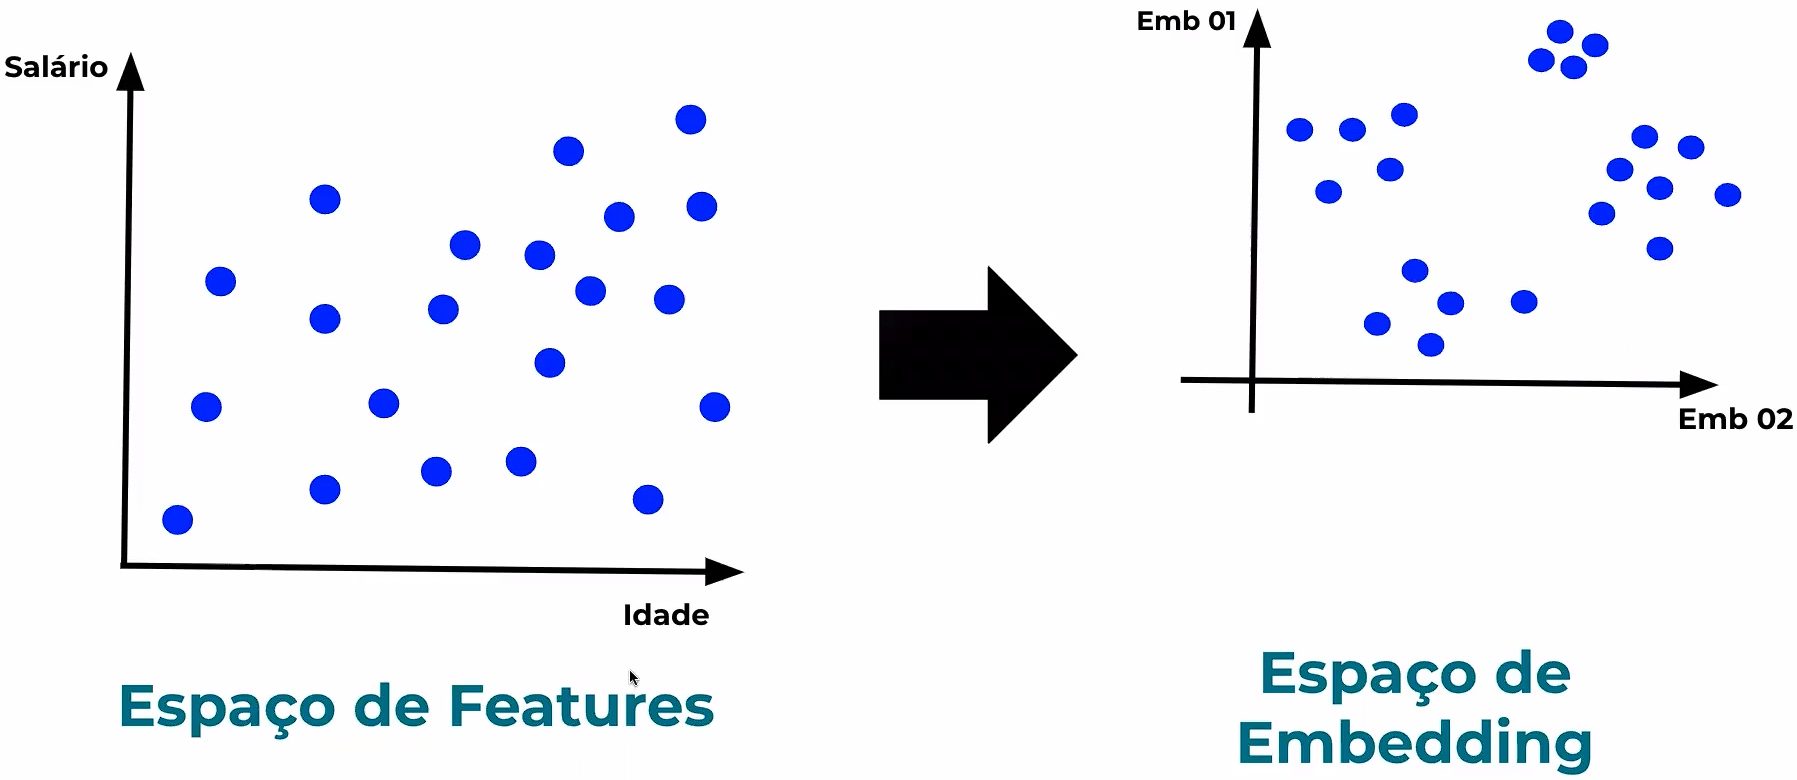

In [53]:
Image('../references/espaco_embedding.png')

### 6.1 PCA

In [54]:
X.shape[1]

14

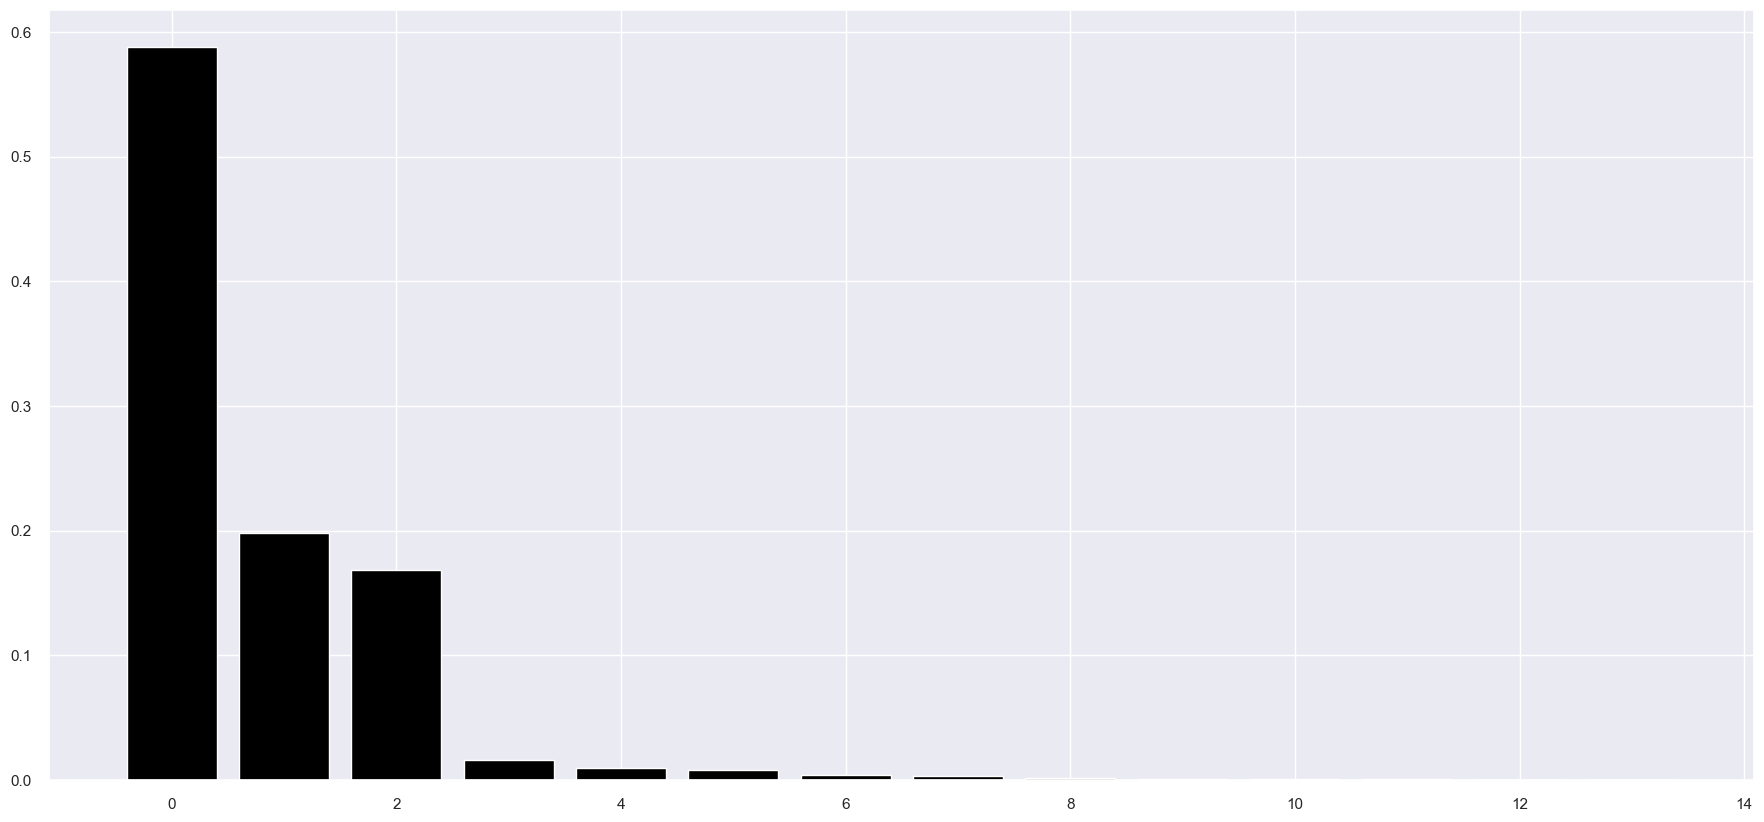

In [55]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black');

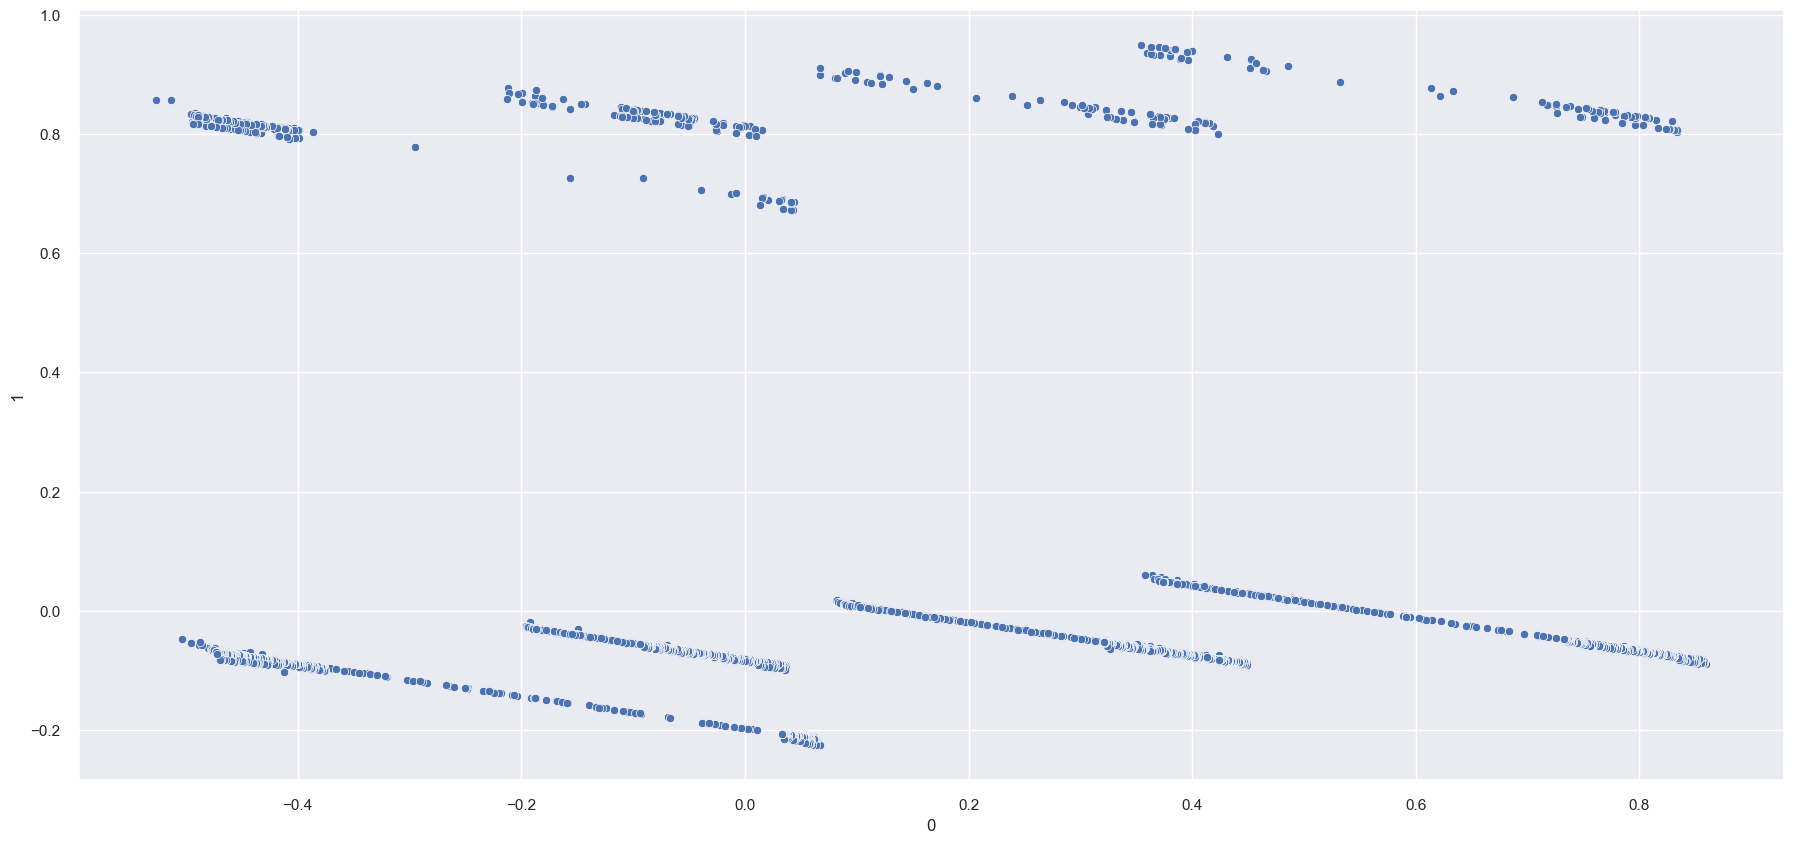

In [56]:
# pca component
df_pca = pd.DataFrame(principal_components)

sns.scatterplot(x=0, y=1, data=df_pca);

## 6.2 UMAP

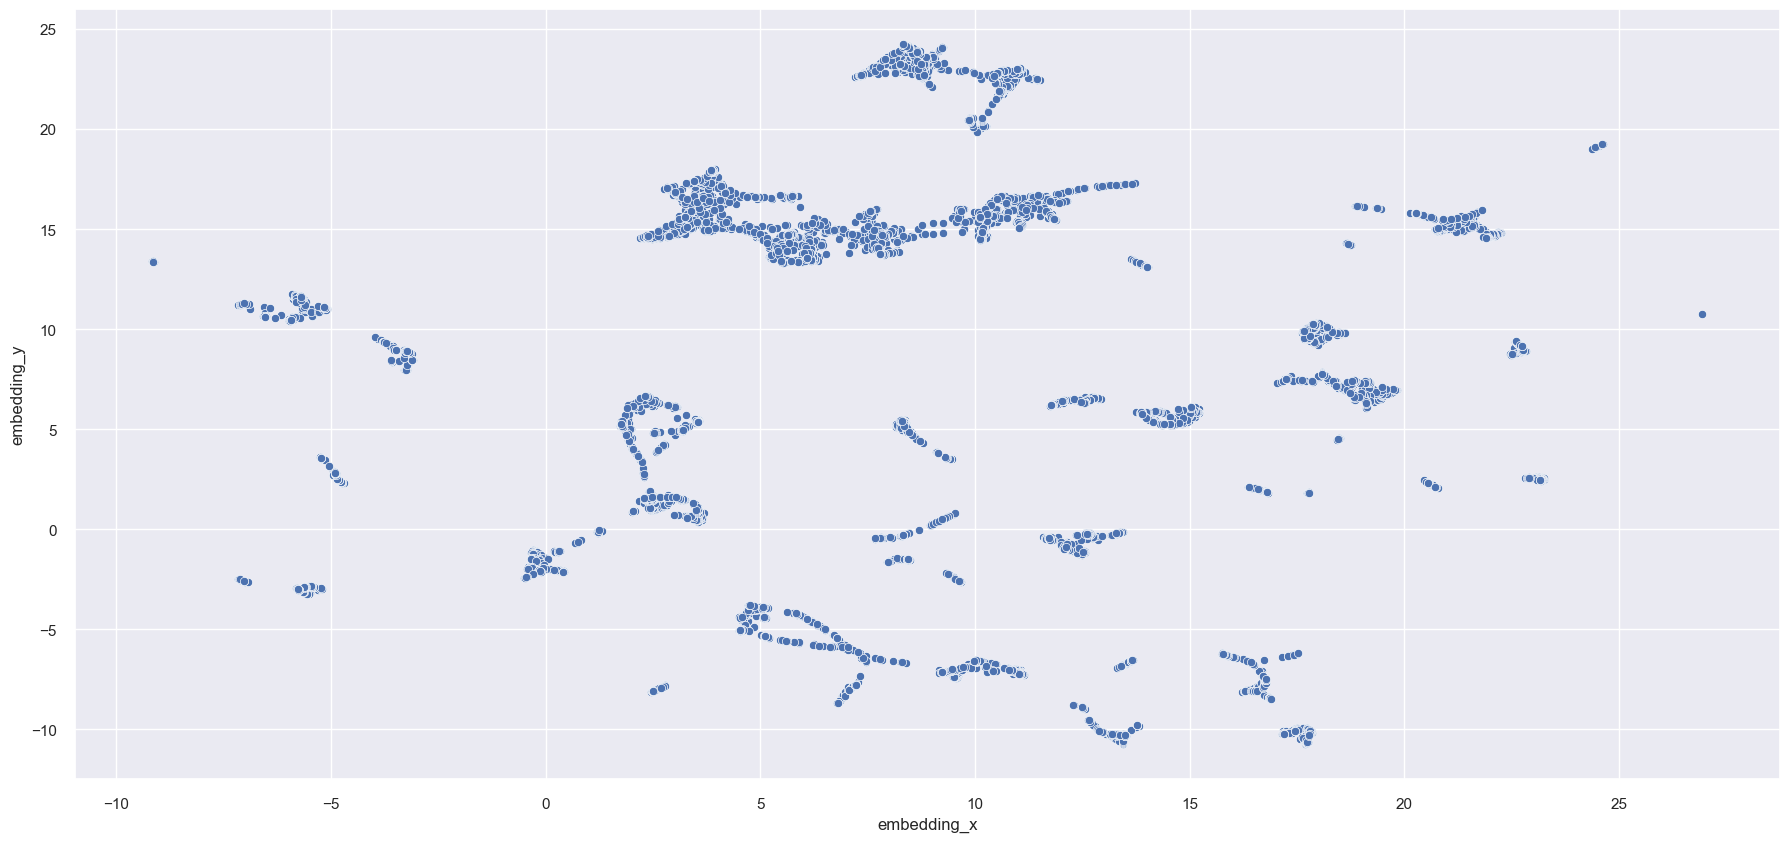

In [57]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

## 6.3 t-SNE

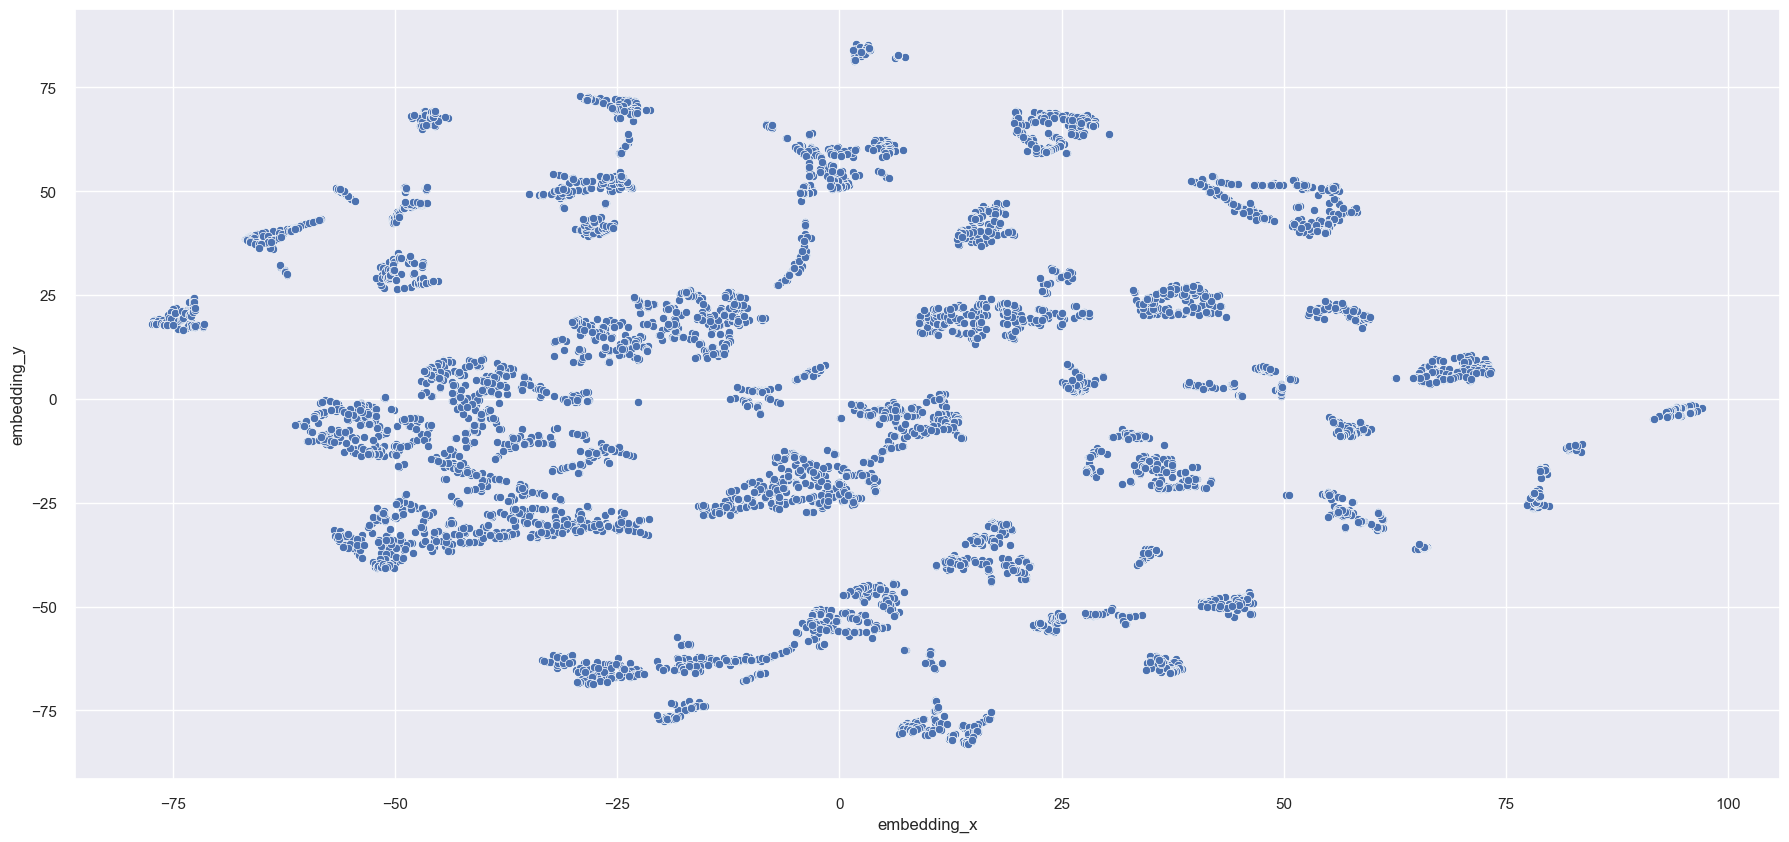

In [58]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]

# Plot t-SNE
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

## 6.4 Tree-based Embedding

### 6.4.1 Fine Tunning Tree

In [59]:
# # model definition
# rf_model = en.RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)


# # Search space for hyper parameters
# search_space = [Integer( 30, 150, name = 'n_estimators'), 
#                 Integer(1, 20, name = 'max_depth'), 
#                 Integer(1, 100, name = 'min_samples_leaf')]


# # applying cross-validation into tunning
# @use_named_args(search_space)
# def model_eval( **params ):
	
#     rf_model.set_params(**params)
#     print(rf_model)
#     rf_model.fit(X, y)
#     yhat = rf_model.predict(X)
    
#     return m.mean_absolute_percentage_error(y, yhat)


# # create checkpoints
# #checkpoint_callback = CheckpointSaver('../models/lgbm_ft.pkl')

# # return results and run bayesian optimize
# result = gp_minimize( model_eval, search_space, n_calls = 300, 
#                       n_initial_points = 10, verbose=True, n_jobs=-1, random_state=42)
# result

In [60]:
# Best tunning
#rf_model = en.RandomForestRegressor(max_depth=20, min_samples_leaf=11, n_estimators=255, n_jobs=-1, random_state=42)

### 6.4.2 Tree Embedding

In [61]:
# training dataset
X = df5.drop(columns=['gross_revenue'], axis=1).copy()
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(max_depth=20, min_samples_leaf=11, n_estimators=255,
                                    n_jobs=-1, random_state=42)

# model training
rf_model.fit(X, y)

# make dataframe for leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

# reducer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

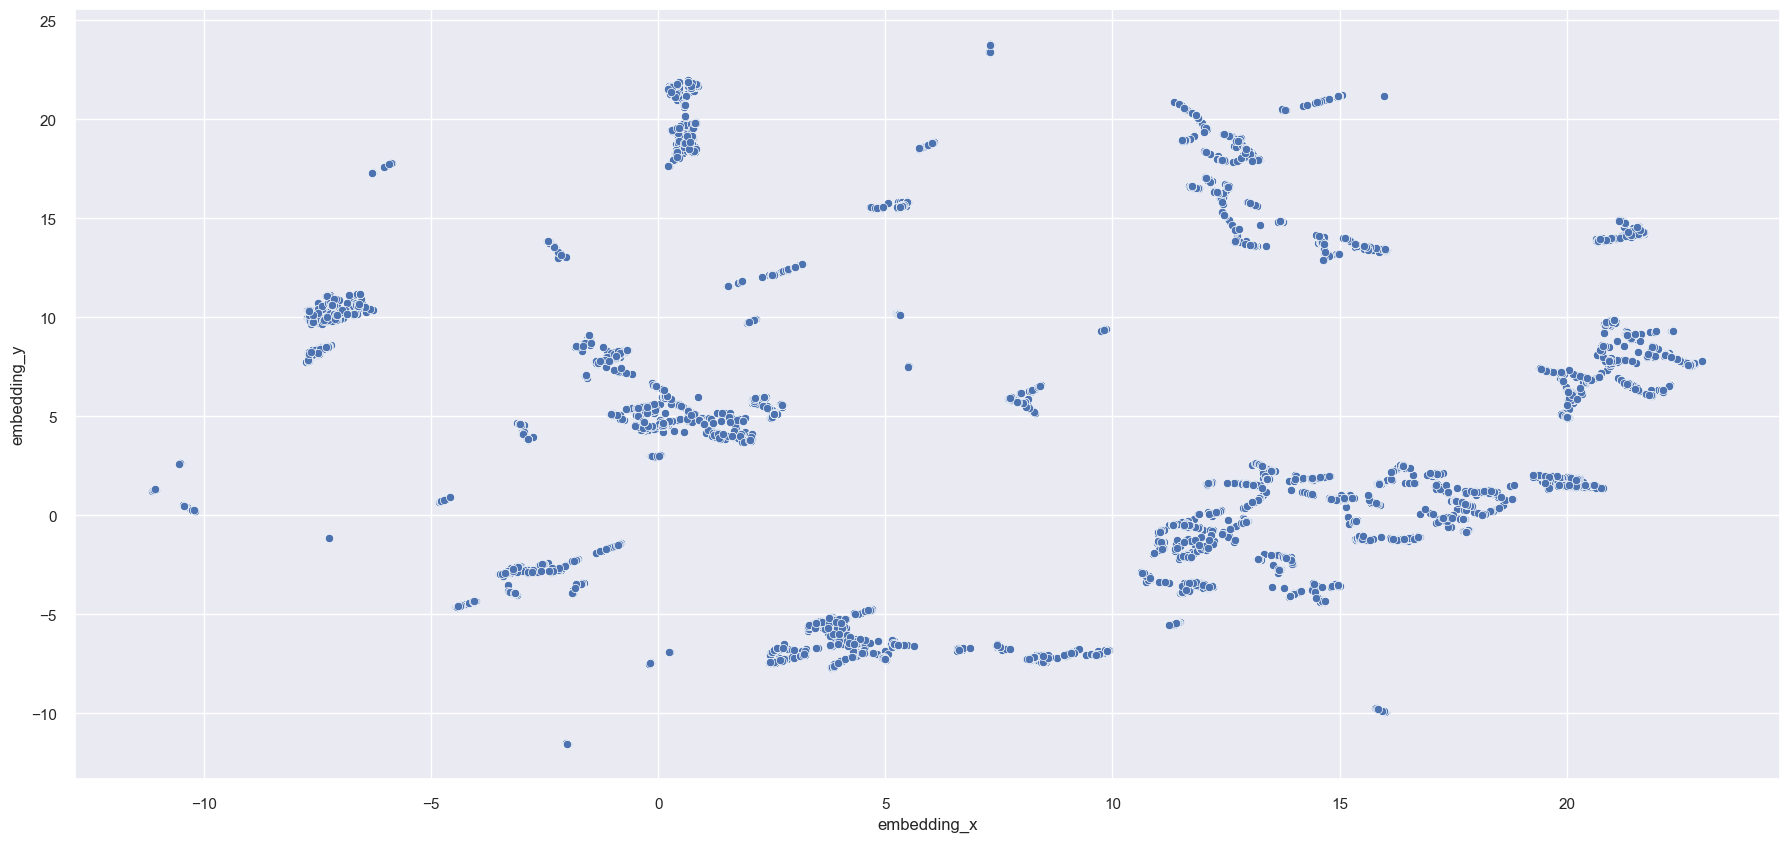

In [62]:
# Plot for UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 7.0 Feature Selection

In [63]:
#cols_selected = ['qty_invoices', 'avg_basket_size', 'avg_ticket', 'qty_products', 'qty_items', 'qtd_returns']
#df7 = df6[cols_selected].copy()

# 8.0 Hyper Parameter Fine Tunning

In [64]:
# drop customer id for ML train
X = df_tree.copy()
X

,embedding_x,embedding_y
0,-7.711,7.818
1,-7.099,9.922
2,0.228,17.650
3,2.464,-6.946
4,20.883,7.315
...,...,...
5675,3.021,12.553
5676,5.733,18.545
5677,1.577,4.695
5678,-3.044,4.587


In [65]:
# make search space for clusters
clusters = np.arange(4, 13, 1)

## 8.1 K-Means

In [66]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # Model training
    kmeans_model.fit(X)

    # Model predict
    labels = kmeans_model.predict(X)

    # Model performance
    sil = m.silhouette_score(X, labels)
    kmeans_list.append(sil)

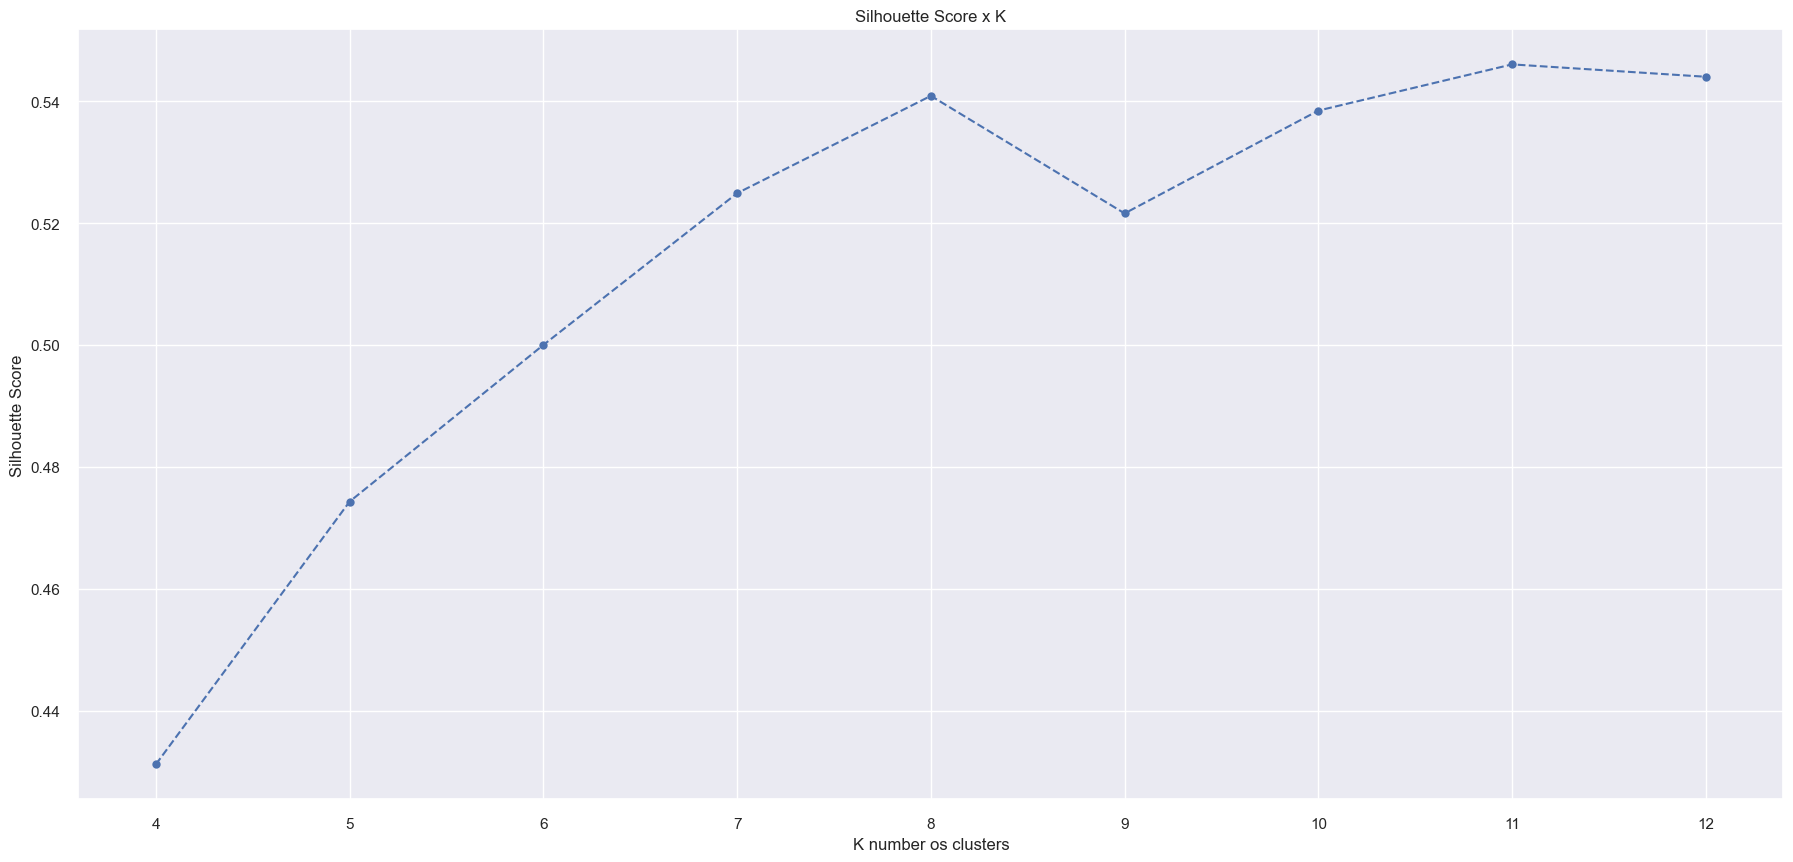

In [67]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K number os clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 8.2 Gaussian Mixture Model (GMM)

In [68]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = mx.GaussianMixture(n_components=k)
    # Model training
    gmm_model.fit(X)

    # Model predict
    labels = gmm_model.predict(X)

    # Model performance
    sil = m.silhouette_score(X, labels)
    gmm_list.append(sil)

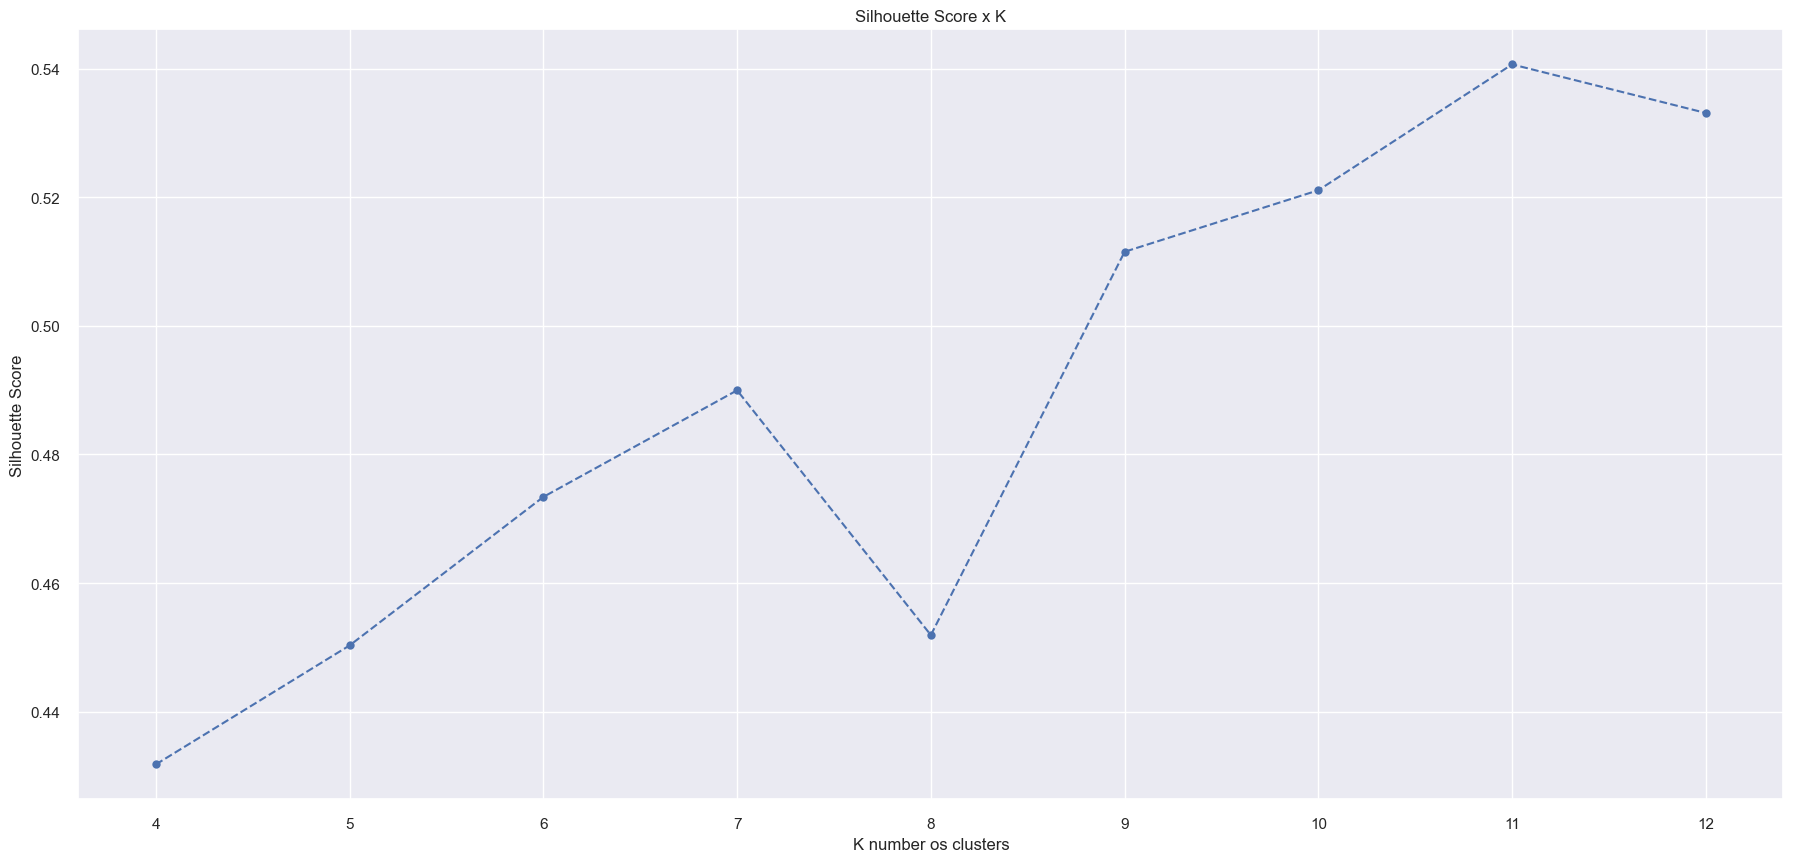

In [69]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K number os clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 8.3 Hierarchical Clustering

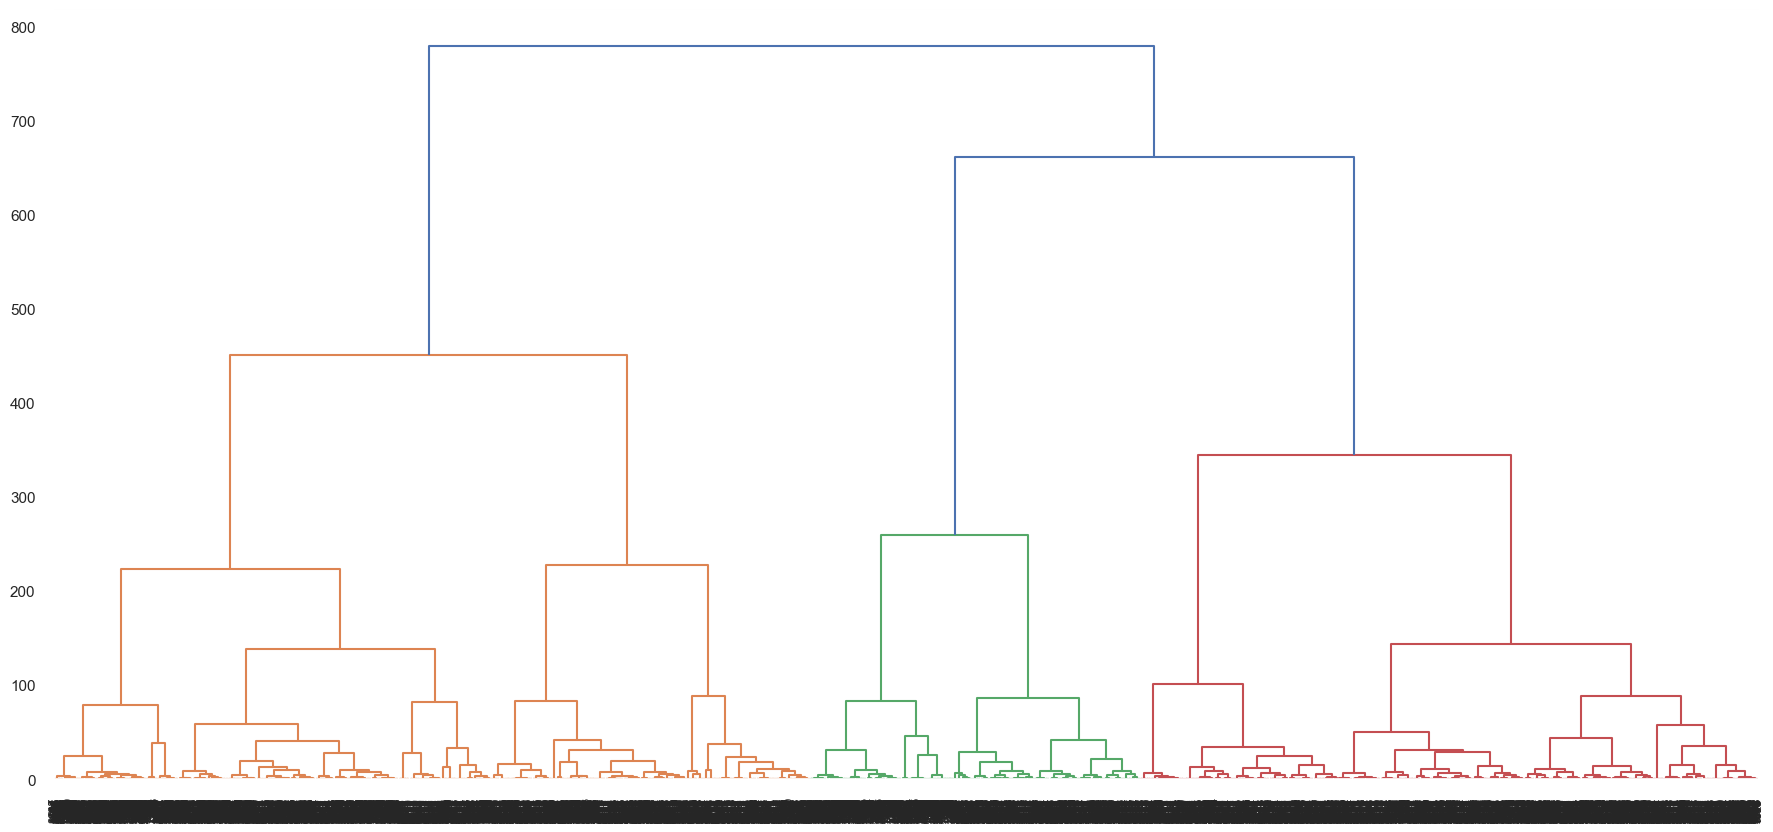

In [70]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

# plot of dendrogram
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)

plt.plot();

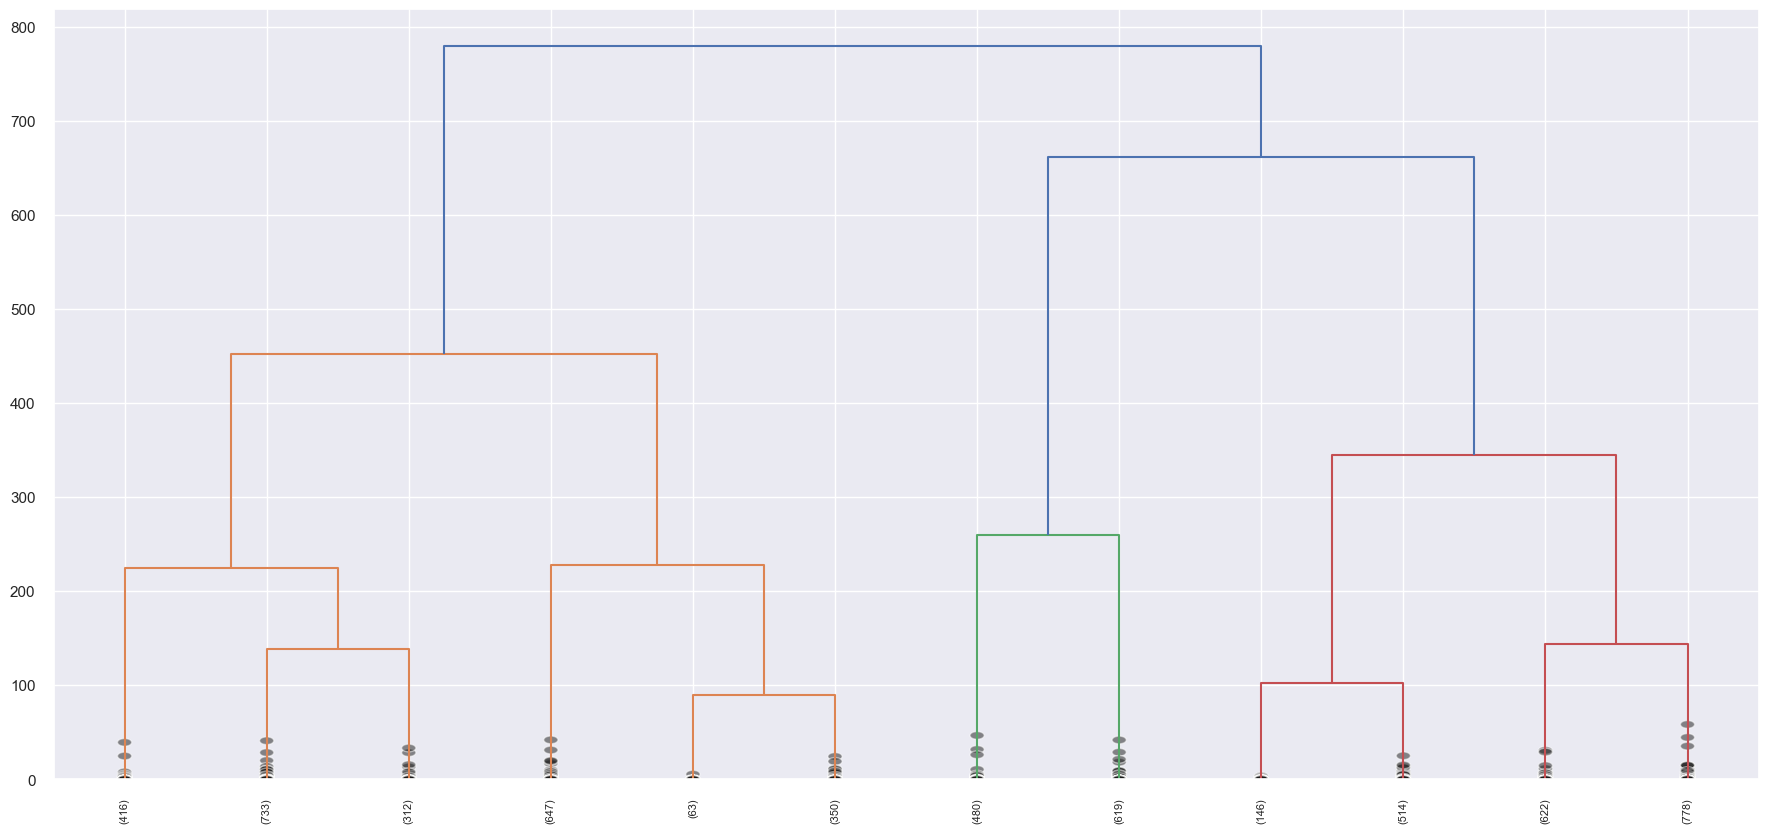

In [71]:
# truncate plot of dendrogram
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)

plt.plot();

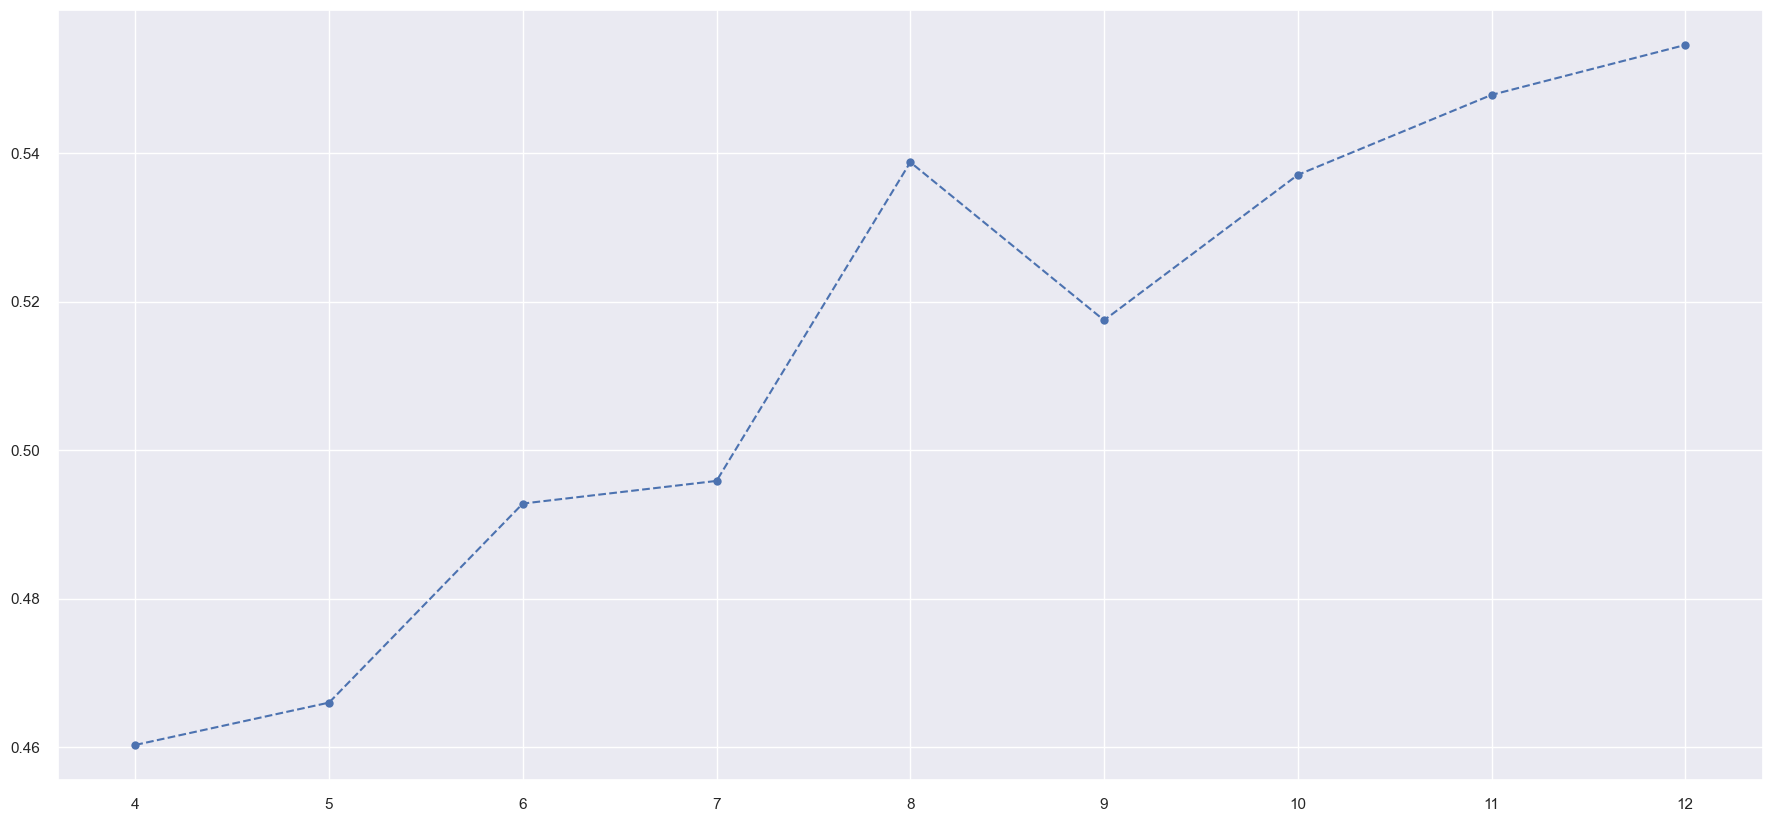

In [72]:
# Silhouette Score
hc_list = []
for k in clusters:
    # Model definition & training
    hc_model = hc.linkage(X, 'ward')

    # Model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # Metrics
    sil = m.silhouette_score(X, labels)
    hc_list.append(sil)

plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b');

## 8.4 DBScan

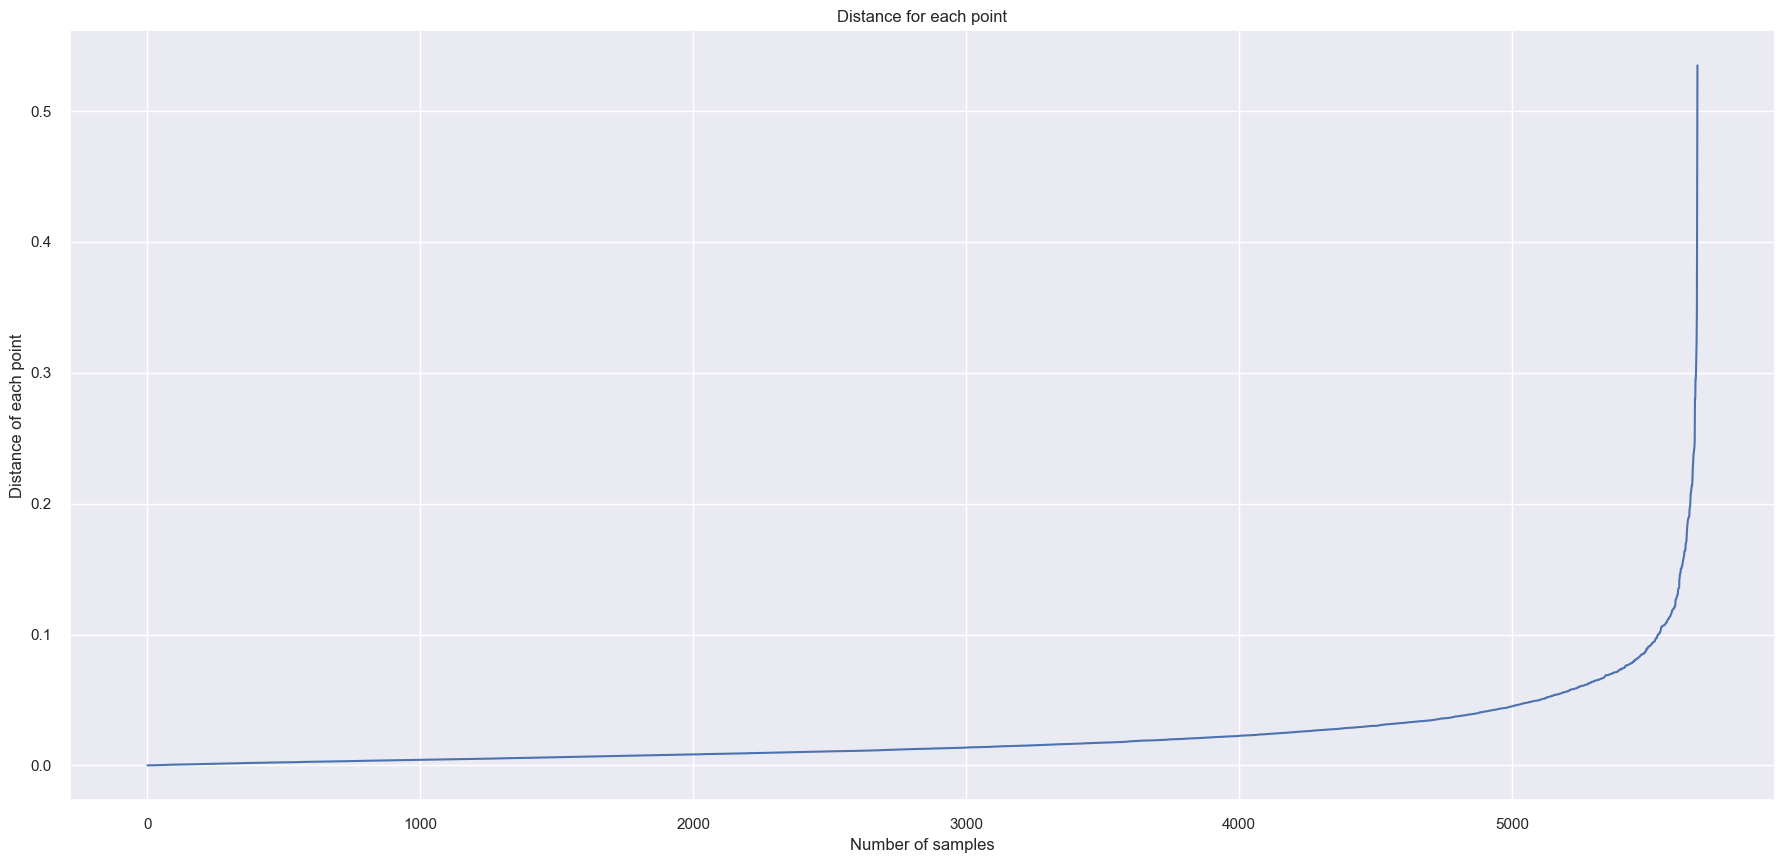

In [73]:
# Search space parameters
eps= 2.0
min_samples = 100

# using nearest model for find number os neighbors for dbscan
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, index = neighbors.kneighbors(X)

distances = np.sort(distances, axis=0)

plt.plot(distances[:,1])
plt.title('Distance for each point')
plt.xlabel('Number of samples')
plt.ylabel('Distance of each point');

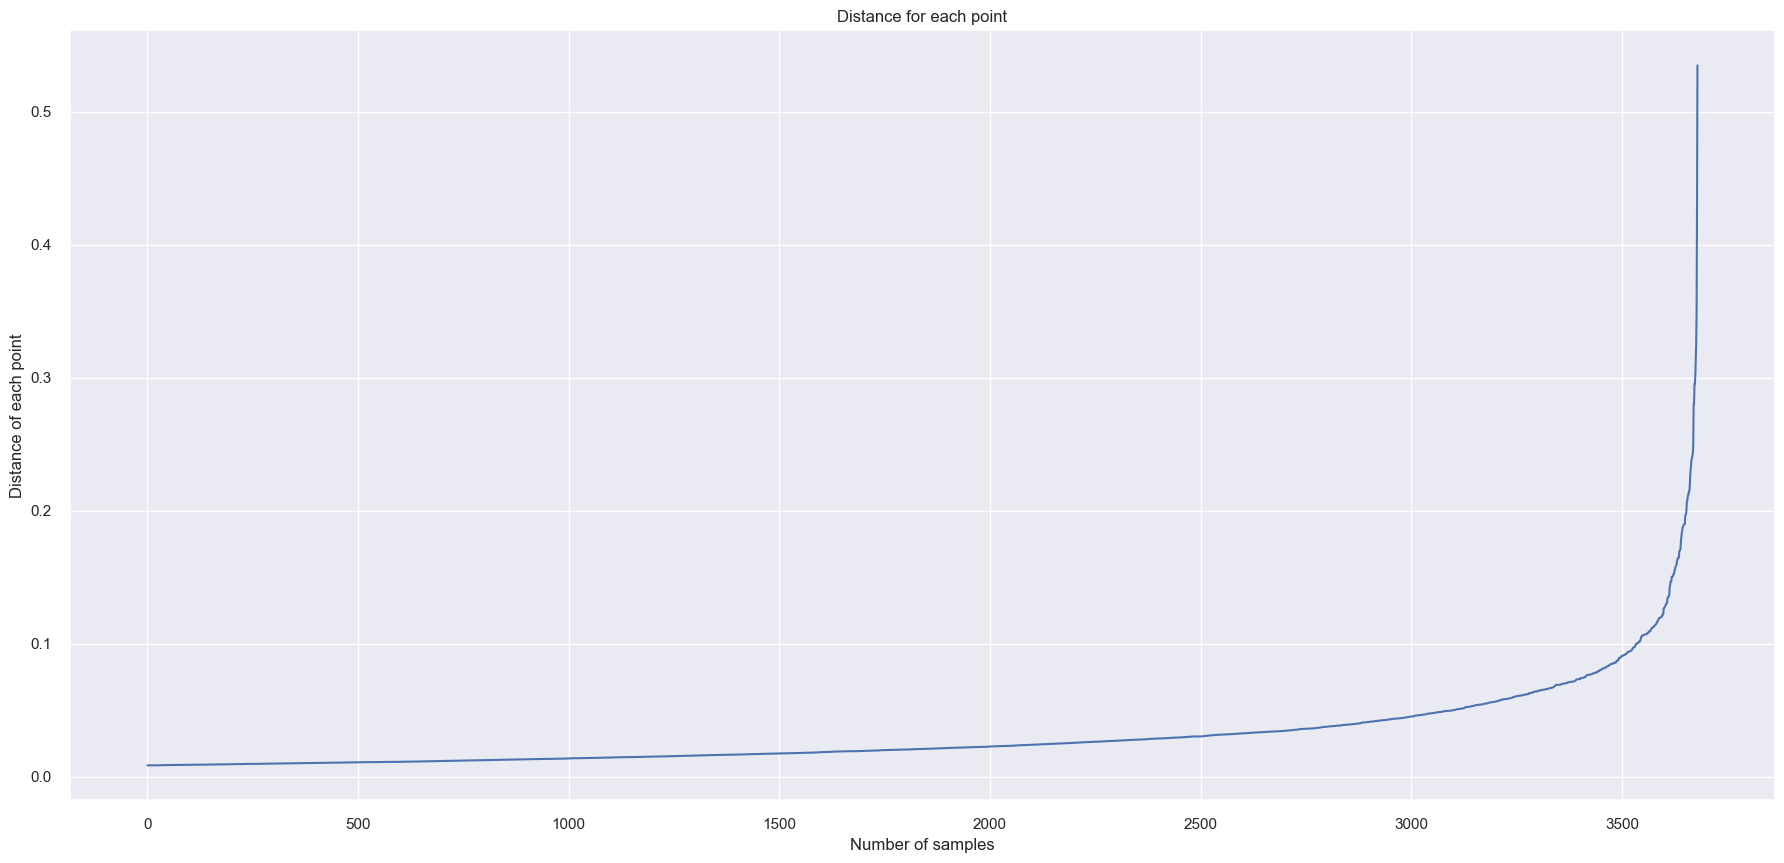

In [74]:
# Make zoom into graph
plt.plot(distances[2000:,1])
plt.title('Distance for each point')
plt.xlabel('Number of samples')
plt.ylabel('Distance of each point');

In [75]:
eps= 2.0
min_samples = 100

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels)
print(f'Silhouette Score: {sil}')
print(f'Number of clusters: {np.unique(labels)}')


Silhouette Score: 0.4756080210208893
Number of clusters: [-1  0  1  2  3  4  5  6  7  8  9 10]


In [76]:
# list for metrics result
dbscan_list = [0.605918, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 8.5 K-Medoids

In [77]:
"""kmedoid_list = []
for k in clusters:
    km_medoid = cme.KMedoids(n_clusters=k, method='pam', random_state=42)
    labels = km_medoid.fit_predict(X)

    sil = m.silhouette_score(X, labels)
    kmedoid_list.append(sil)"""

#pickle.dump(kmedoid_list, open('../data/interim/kmedoid_list.pkl', 'wb'))

kmedoid_list = pickle.load(open('../data/interim/kmedoid_list.pkl', 'rb'))

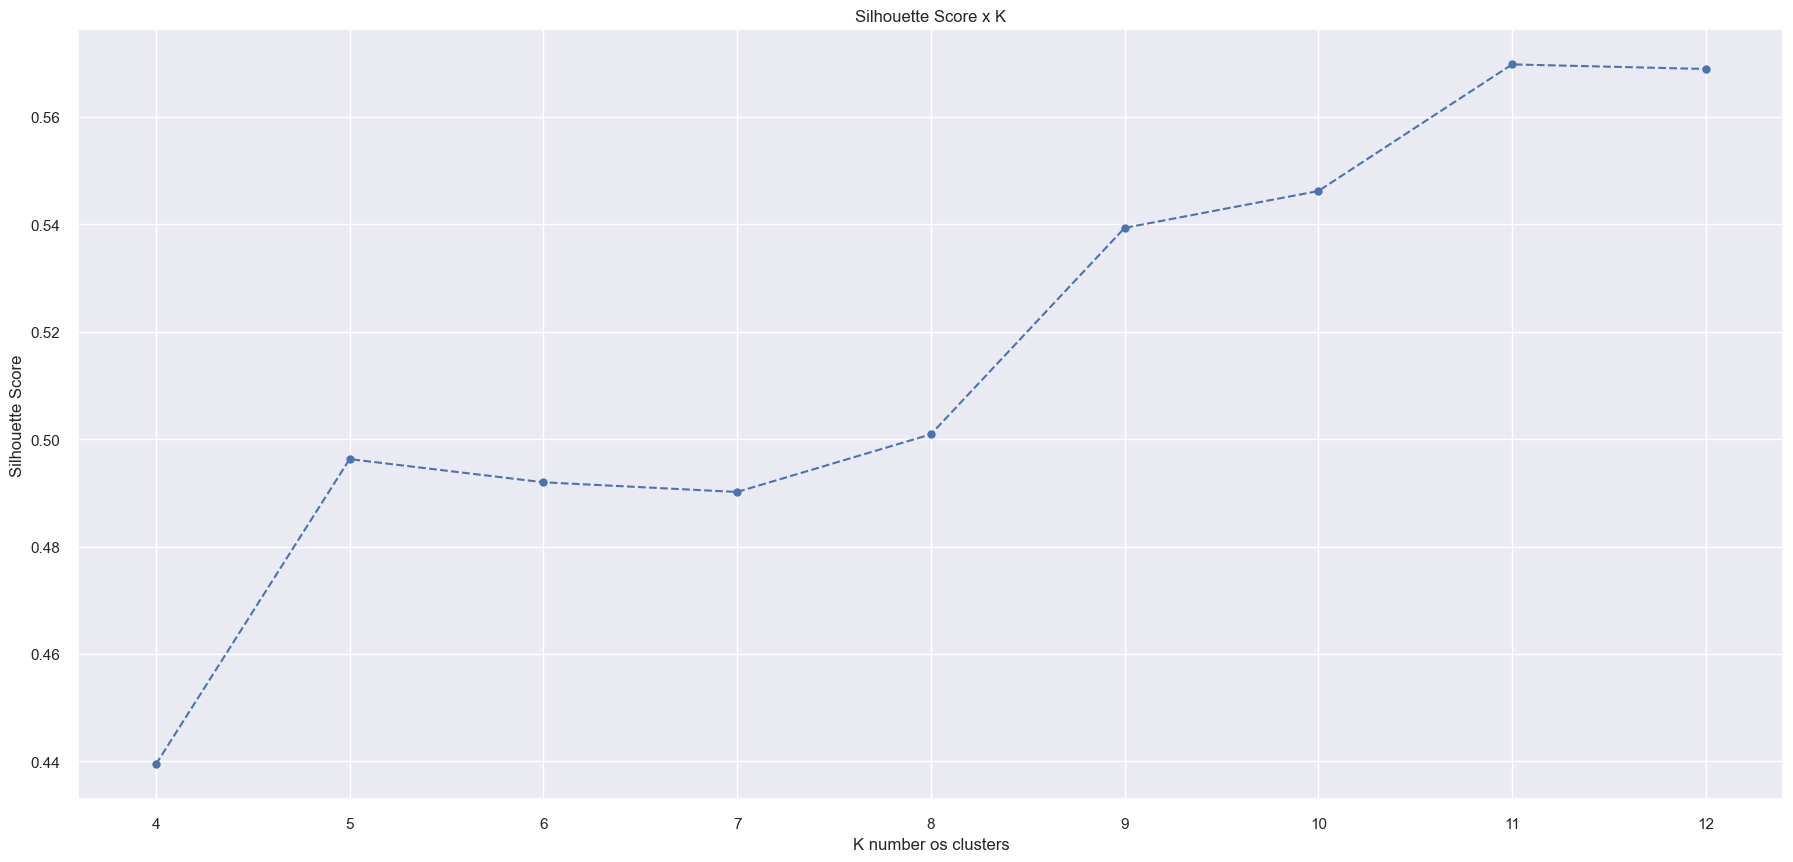

In [78]:
plt.plot(clusters, kmedoid_list, linestyle='--', marker='o', color='b')
plt.xlabel('K number os clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 8.6 HDBScan

In [79]:
# Model definition
hdbscan_model = HDBSCAN(min_cluster_size=145, min_samples=100)

# model training and predict
labels = hdbscan_model.fit_predict(X)


sil = m.silhouette_score(X, labels)
print(f'Silhouette Score: {sil}')
print(f'Number of clusters: {np.unique(labels)}')

Silhouette Score: 0.4346098005771637
Number of clusters: [-1  0  1  2  3  4  5  6  7  8  9]


## 8.7 Results 

In [80]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC          SS    SS    SS    SS
#  DBSCAN      SS    SS    SS    SS

# Make dataframe for results in each clusters
df_result = pd.DataFrame(
                        {'KMeans': kmeans_list,
                        'GMM': gmm_list,
                        'HC': hc_list,
                        'KMedoid': kmedoid_list}).T
                        #'DBScan': dbscan_list

df_result.columns = clusters

df_result.style.highlight_max(color='darkgreen', axis=1)

,4,5,6,7,8,9,10,11,12
KMeans,0.431221,0.474321,0.500012,0.524896,0.540866,0.521587,0.538450,0.546028,0.543998
GMM,0.431818,0.450312,0.473404,0.489980,0.451920,0.511519,0.521085,0.540655,0.533099
HC,0.460341,0.466040,0.492831,0.495881,0.538779,0.517508,0.537075,0.547838,0.554561
KMedoid,0.439433,0.496279,0.491966,0.490161,0.500893,0.539334,0.546205,0.569784,0.568927


## 8.8 Silhouette Analysis

 For K = 4. Silhouette Score: 0.46034106612205505
 For K = 5. Silhouette Score: 0.4660404324531555
 For K = 6. Silhouette Score: 0.4928314685821533
 For K = 7. Silhouette Score: 0.49588069319725037
 For K = 8. Silhouette Score: 0.5387789607048035
 For K = 9. Silhouette Score: 0.5175081491470337
 For K = 10. Silhouette Score: 0.537074625492096
 For K = 11. Silhouette Score: 0.5478382110595703
 For K = 12. Silhouette Score: 0.5545614957809448


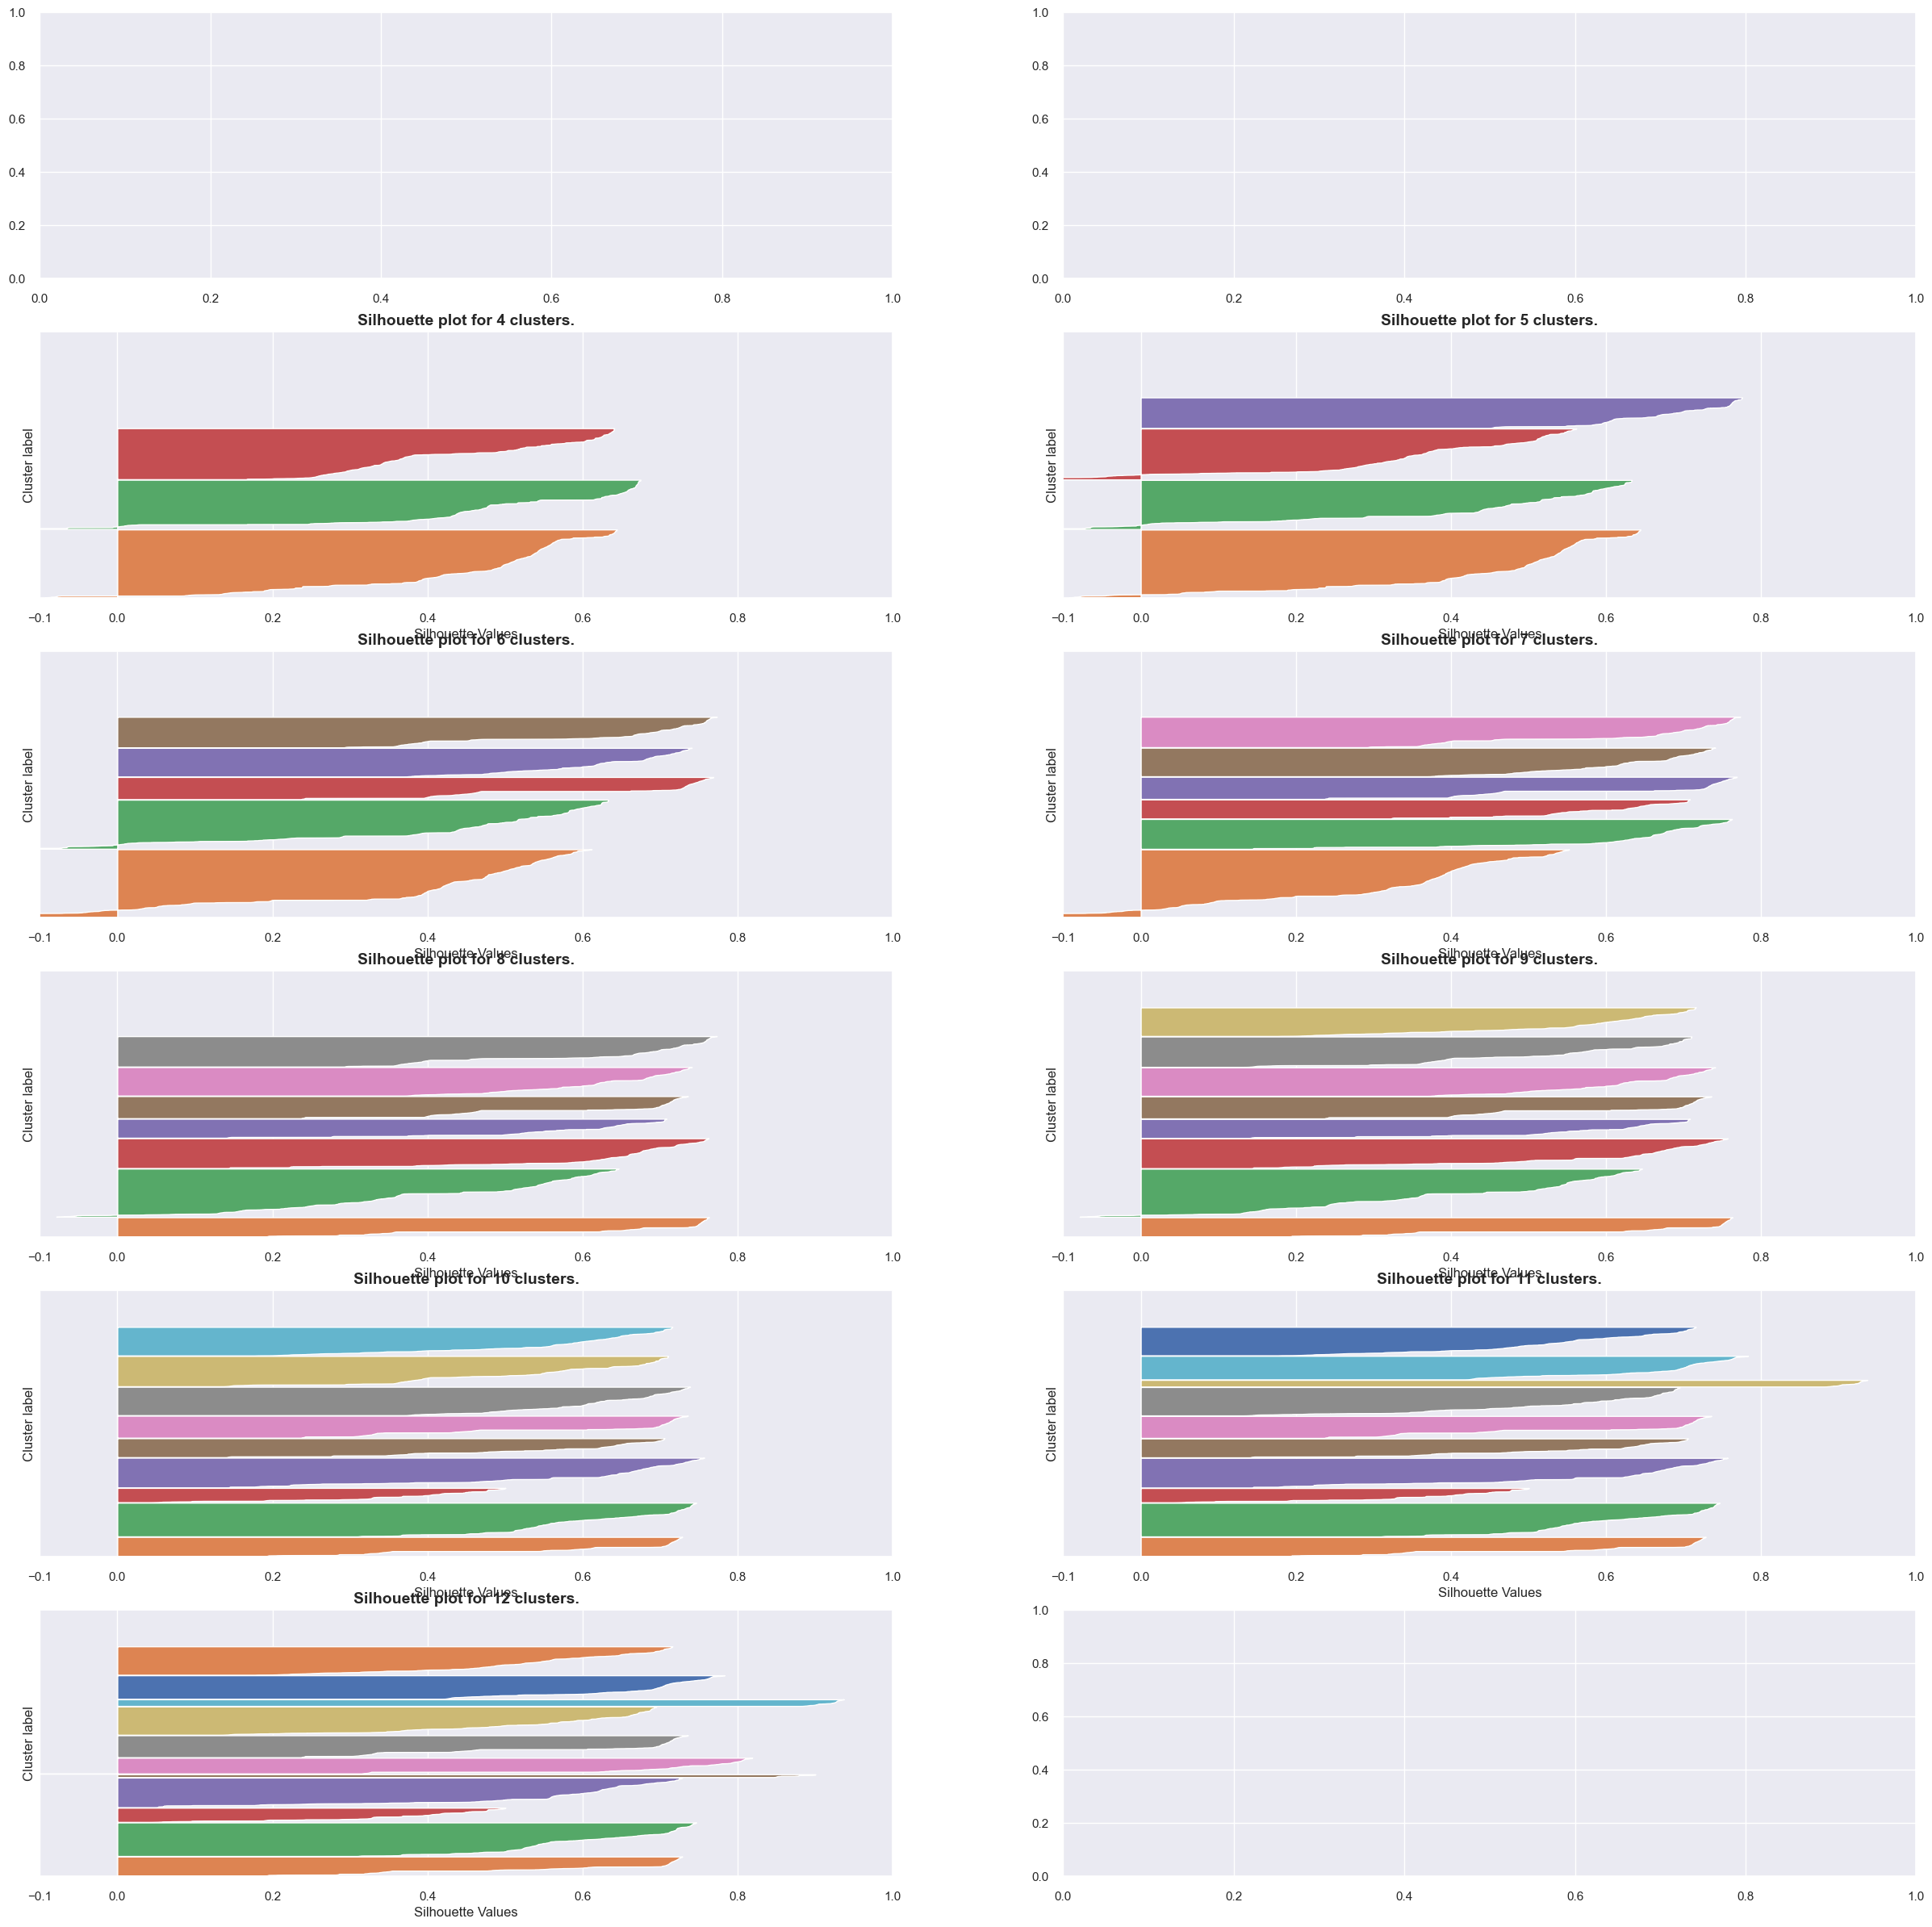

In [81]:
plot_silhouette(X=X, clusters=clusters)

# 9.0 Machine Learning Modeling

## 9.1 HC

In [82]:
X = df_tree.copy()

In [83]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

# Model predict
labels = hc.fcluster(hc_model, 8, criterion='maxclust')

# Metrics
sil = m.silhouette_score(X, labels)

## 9.2 Cluster Validation

In [84]:
sil = m.silhouette_score(X, labels)
print(f'Silhouette Score: {sil}')
print(f'Number of clusters: {np.unique(labels)}')

Silhouette Score: 0.5387789607048035
Number of clusters: [1 2 3 4 5 6 7 8]


# 10.0 Cluster Analysis

In [85]:
df10 = X.copy()
df10['cluster'] = labels
df10.head()

,embedding_x,embedding_y,cluster
0,-7.711,7.818,1
1,-7.099,9.922,1
2,0.228,17.650,5
3,2.464,-6.946,3
4,20.883,7.315,7


## 10.1 Visualization Inspection

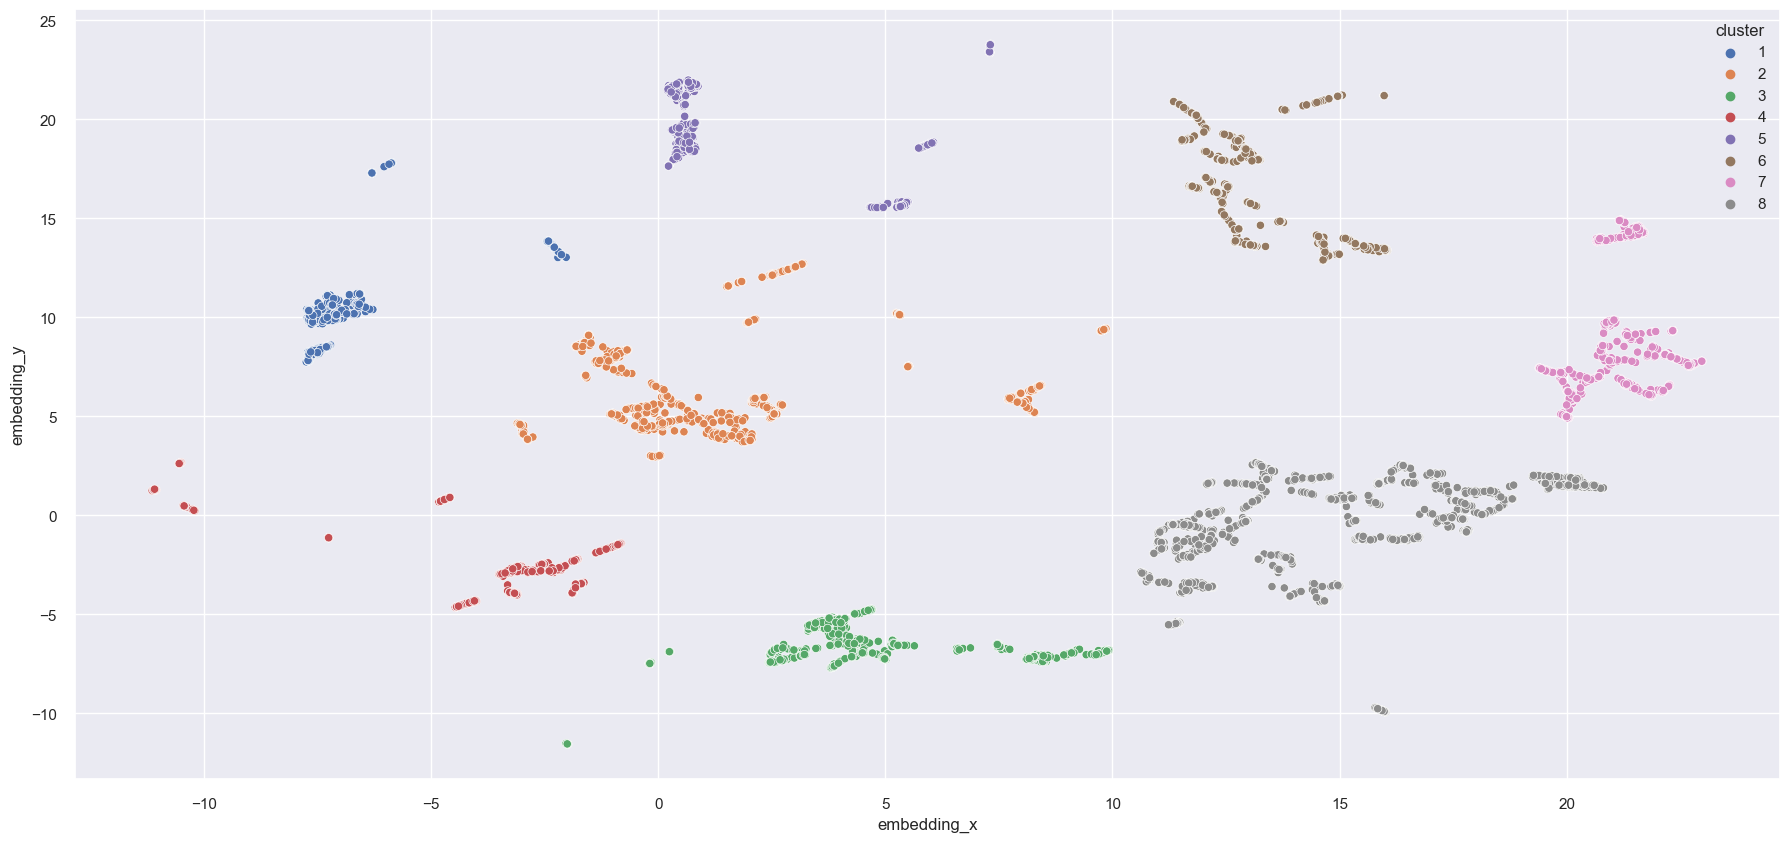

In [86]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df10, palette='deep');

## 10.2 2D Plot

In [87]:
df_vis = df10.copy()
#sns.pairplot(df_vis, hue='cluster');

## 10.3 UMAP

In [88]:
#reducer = umap.UMAP(n_neighbors=80, random_state=42)
#embedding = reducer.fit_transform(X)

# Embedding
#df_vis['embedding_x'] = embedding[:,0]
#df_vis['embedding_y'] = embedding[:,1]

# Plot UMAP
#sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_vis['cluster'].unique())), data=df_vis);

## 10.4 Cluster Profile

In [144]:
df10 = df4.reset_index( drop=True).copy()
df10['cluster'] = labels

# Number of customers
df_cluster = df10[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df10[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df10[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg qty products
df_avg_recency_days = df10[['qty_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Frequency
df_invoice_no = df10[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Returns ratio
df_ticket = df10[['returns_ratio', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

# Cluster names from RFM Model
names = {1 : "Insiders",
         5 : "Loyal Customers",
         2 : "Potential Loyalists",
         4 : "Promissing ",
         3 : "Need Attention",
         8 : "Hibernating",
         7 : "Price Sensitive",
         6 : "Churn"}
df_cluster['cluster_name'] = df_cluster['cluster'].map(names)

df_cluster = df_cluster[['cluster', 'cluster_name', 'customer_id', 'perc_customer', 'gross_revenue', 'recency_days', 'qty_products',	'frequency', 'returns_ratio']].sort_values('gross_revenue', ascending=False)
df_cluster

,cluster,cluster_name,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,returns_ratio
0,1,Insiders,416,7.324,8299.489,38.005,244.173,0.028,0.015
4,5,Loyal Customers,480,8.451,5976.285,40.052,276.173,0.031,0.014
1,2,Potential Loyalists,1045,18.398,1864.094,87.016,144.840,0.009,0.011
3,4,Promissing,413,7.271,1006.377,106.910,82.354,0.007,0.011
2,3,Need Attention,647,11.391,722.785,97.291,55.730,0.007,0.009
7,8,Hibernating,1400,24.648,467.971,135.264,38.179,0.004,0.011
6,7,Price Sensitive,660,11.620,232.572,181.074,21.441,0.003,0.008
5,6,Churn,619,10.898,57.489,196.901,6.522,0.003,0.002


### Cluster Name

- 1 Cluster Insiders
- 5 Cluster More frequency          
- 2 Cluster Less days               
- 4 Cluster More Products           
- 3 Cluster Even More Products       
- 8 Cluster Even Less days
- 7 Cluster Spend Money 
- 6 Cluster More Buy

# 11.0 EDA For Clusters

In [156]:
df11 = df10.copy()

names = {1 : "Insiders",
         5 : "Loyal Customers",
         2 : "Potential Loyalists",
         4 : "Promissing ",
         3 : "Need Attention",
         8 : "Hibernating",
         7 : "Price Sensitive",
         6 : "Churn"}
df11['cluster_name'] = df11['cluster'].map(names)

## 11.1 MindMap de hipoteses

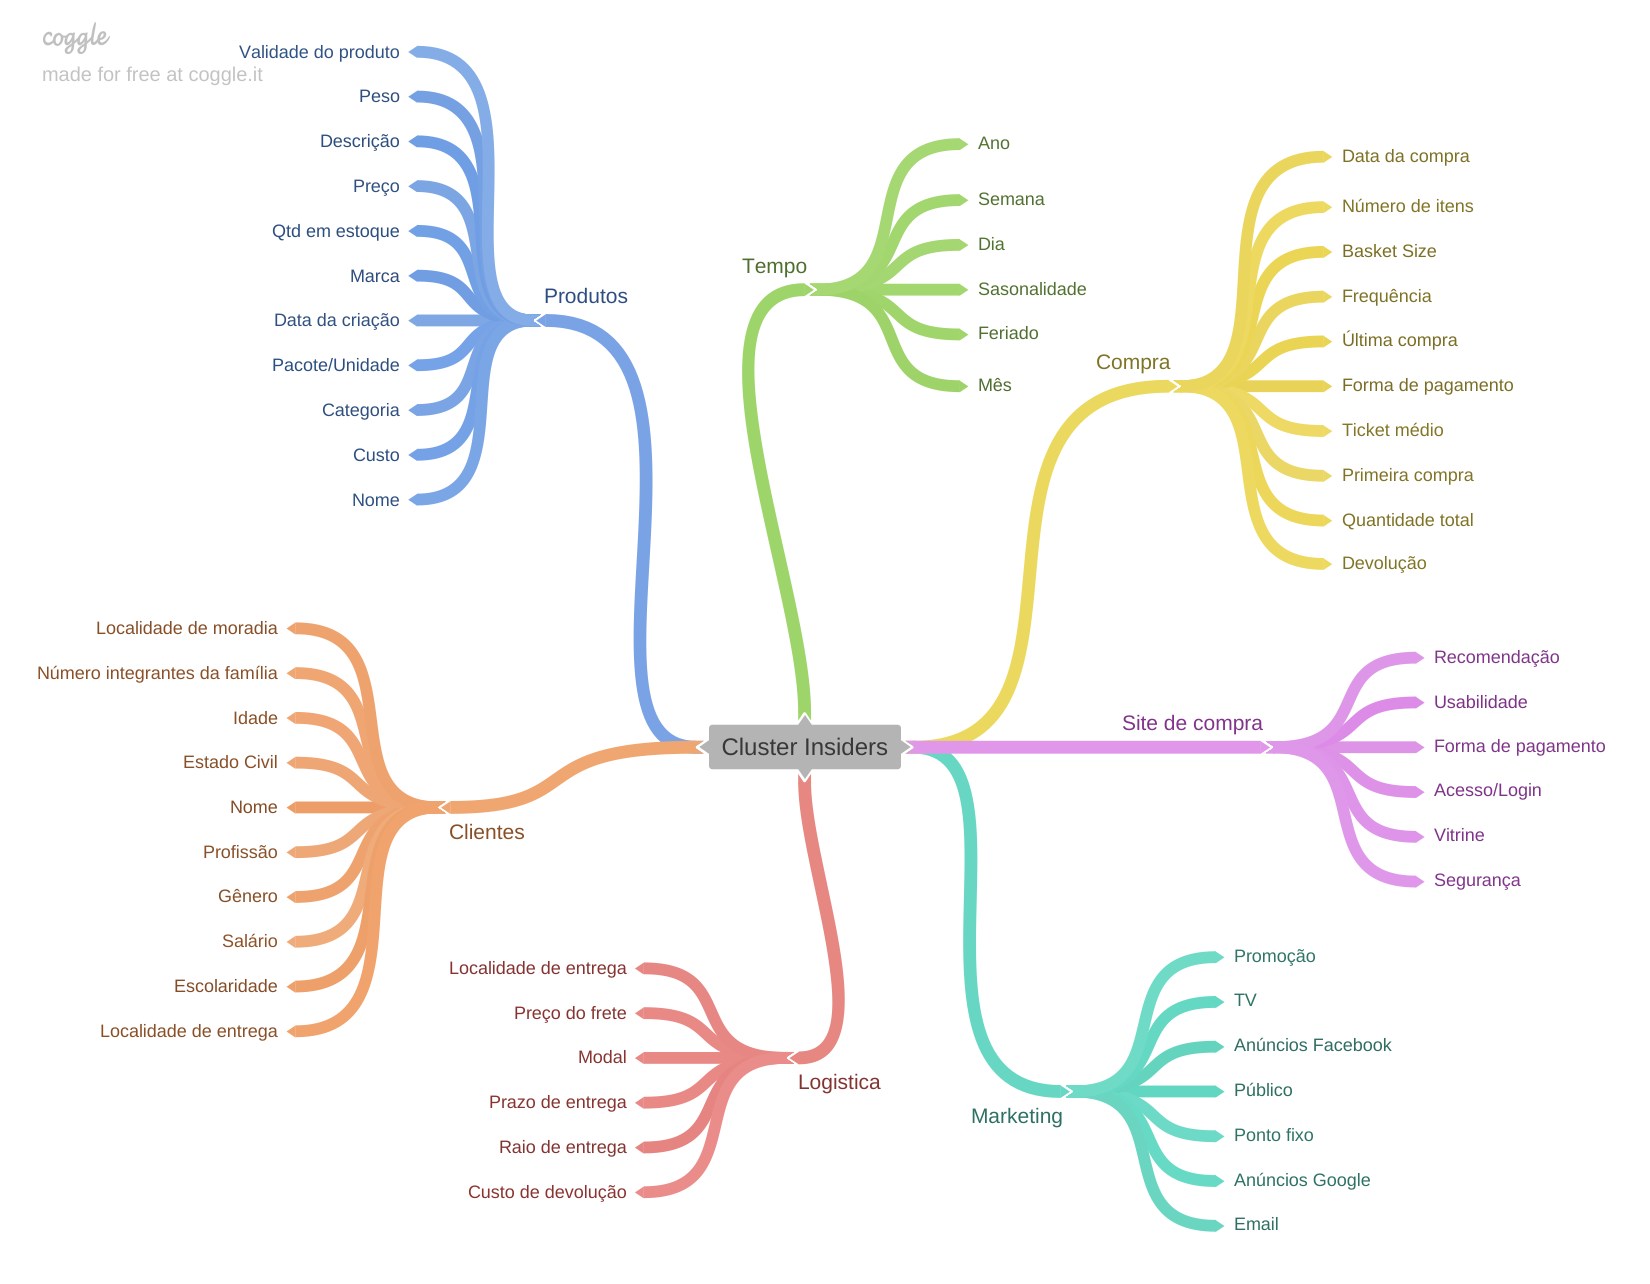

In [90]:
Image('../reports/mindmap_hypotesis.png')

## 11.2 Hipóteses de Negócio

### 11.2.1 Hipóteses de Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster 'promissing'.
3. Os clientes do cluster insiders possuem em média um basket size acima de 5 produtos.
4. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
5. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
6. Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.
7. A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.

### 11.2.2 Hipóteses de Clientes

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

### 11.2.3 Hipóteses de Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A media dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a media de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.
6. Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes

### 11.2.4 Priorização das hipóteses

1. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster 'promissing'.
2. Os clientes do cluster insiders possuem em média basket size acima de 5 produtos.
3. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
4. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
5. A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.
6. A media dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a media de todos os preços dos produtos.
7. Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes

## 11.3 Validação das hipóteses

##### **H1.** Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster 'Promissing'.
**TRUE** O cluster de Insiders possui 63,78% a mais no ticket médio.

In [158]:
avg_ticket_c1 = df10[['avg_ticket']][df10['cluster'] == 1].mean() # Average ticket for cluster insider
avg_ticket_c4 = df10[['avg_ticket']][df10['cluster'] == 4].mean() # Average ticket for cluster "more products"

perc_c1 = ((avg_ticket_c1 - avg_ticket_c4) / avg_ticket_c1)*100

print(f'Cluster insiders: {avg_ticket_c1[0]:.2f} and cluster More products: {avg_ticket_c4[0]:.2f}')
print(f'Cluster Insiders (1) has average ticket {perc_c1.values[0]:.2f} % more than Cluster "PROMISSING" (4).')

Cluster insiders: 57.03 and cluster More products: 20.66
Cluster Insiders (1) has average ticket 63.78 % more than Cluster "PROMISSING" (4).


##### **H2.** Os clientes do cluster insiders possuem em média um basket size acima de 5 produtos.

**TRUE** Os clientes Insiders possuem em média um tamanho de cesta de apoximadamente 464 itens.

In [164]:
# Make basket size
aux = df11.copy()
aux['basket_size'] = aux.apply(lambda x: x['qty_items'] / x['qty_invoices'], axis=1)

# Calculate basket size per cluster for plot
aux01 = aux[['cluster_name', 'basket_size']].groupby('cluster_name').mean().reset_index()
order = list(aux01.groupby('cluster_name').mean().reset_index().sort_values('basket_size', ascending=False)['cluster_name'])

# Mean value for cluster Insider
aux = aux[aux['cluster_name'] == 'Insiders']
aux[['cluster_name', 'basket_size']].groupby('cluster_name').mean().reset_index()

,cluster_name,basket_size
0,Insiders,464.146


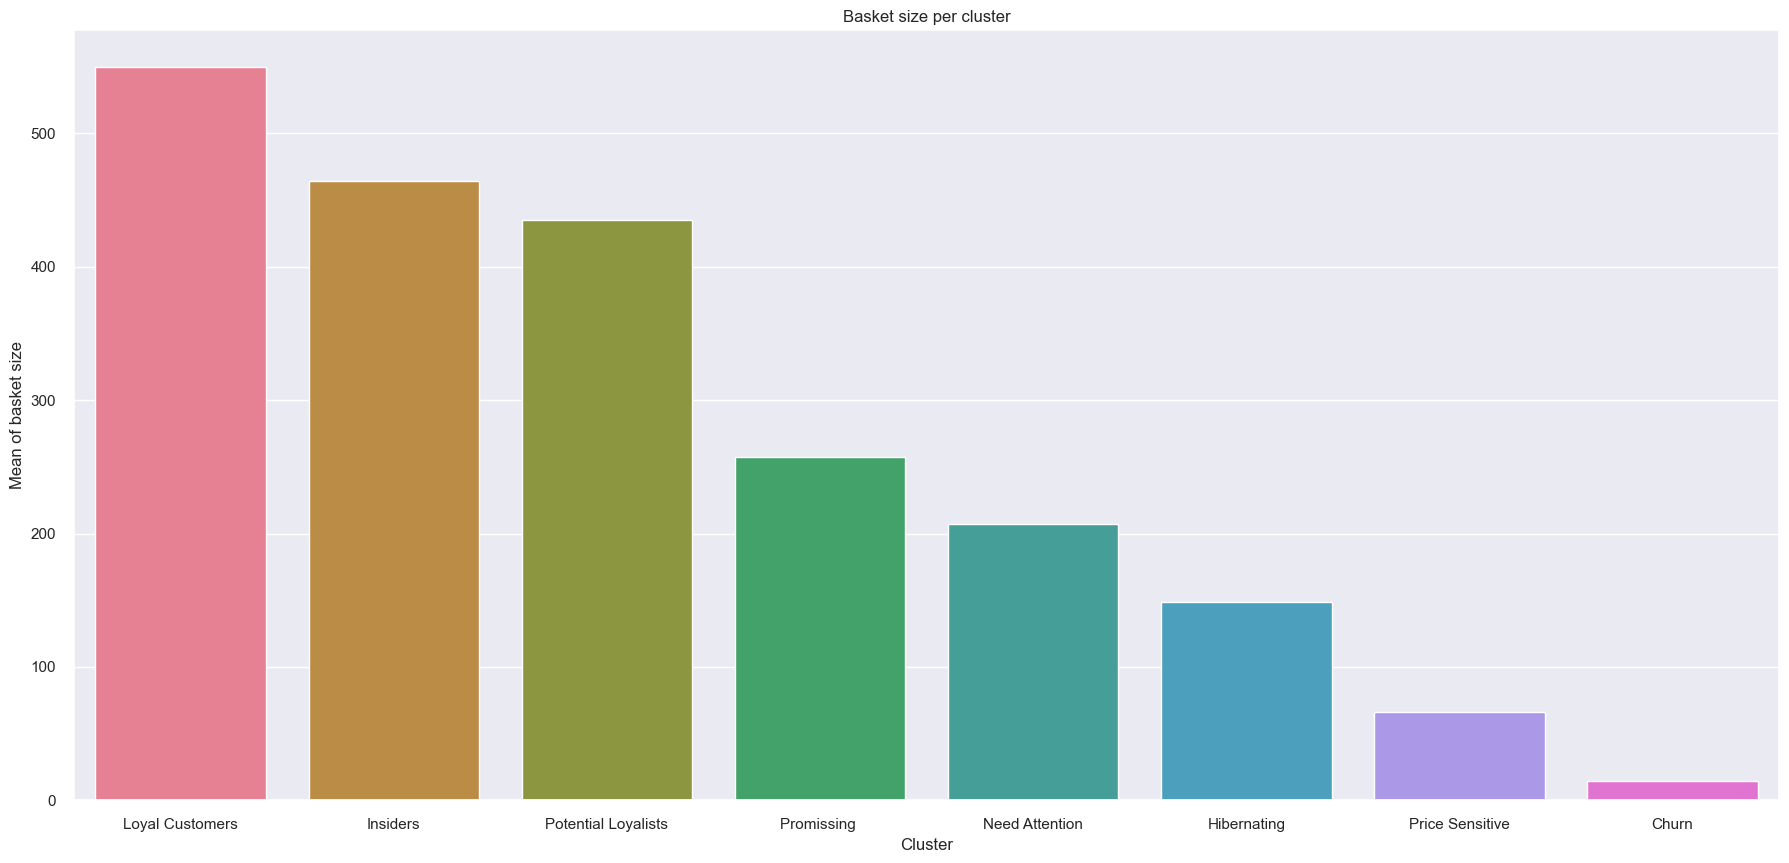

In [163]:
sns.barplot(x='cluster_name', y='basket_size', data=aux01, palette='husl', order=order)
plt.title('Basket size per cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean of basket size');

##### **H3.** Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
**TRUE** Os clientes insiders correspondem a 19,27% do volume de produtos.

In [174]:
# Sum of products from each cluster
aux = df11[['cluster_name', 'qty_products']].groupby('cluster_name').sum().reset_index()

# Products from cluster insiders
prod_c1 = aux.loc[2, 'qty_products']

# Sum from all clusters
prod_total = df10['qty_products'].sum()

print(f'Cluster insiders: {prod_c1:.2f} and total clusters: {prod_total:.2f}')
print(f'Percentage of produtcs buy from Cluster Insiders: {(prod_c1 / prod_total)*100:.2f} %')

Cluster insiders: 101576.00 and total clusters: 527205.00
Percentage of produtcs buy from Cluster Insiders: 19.27 %


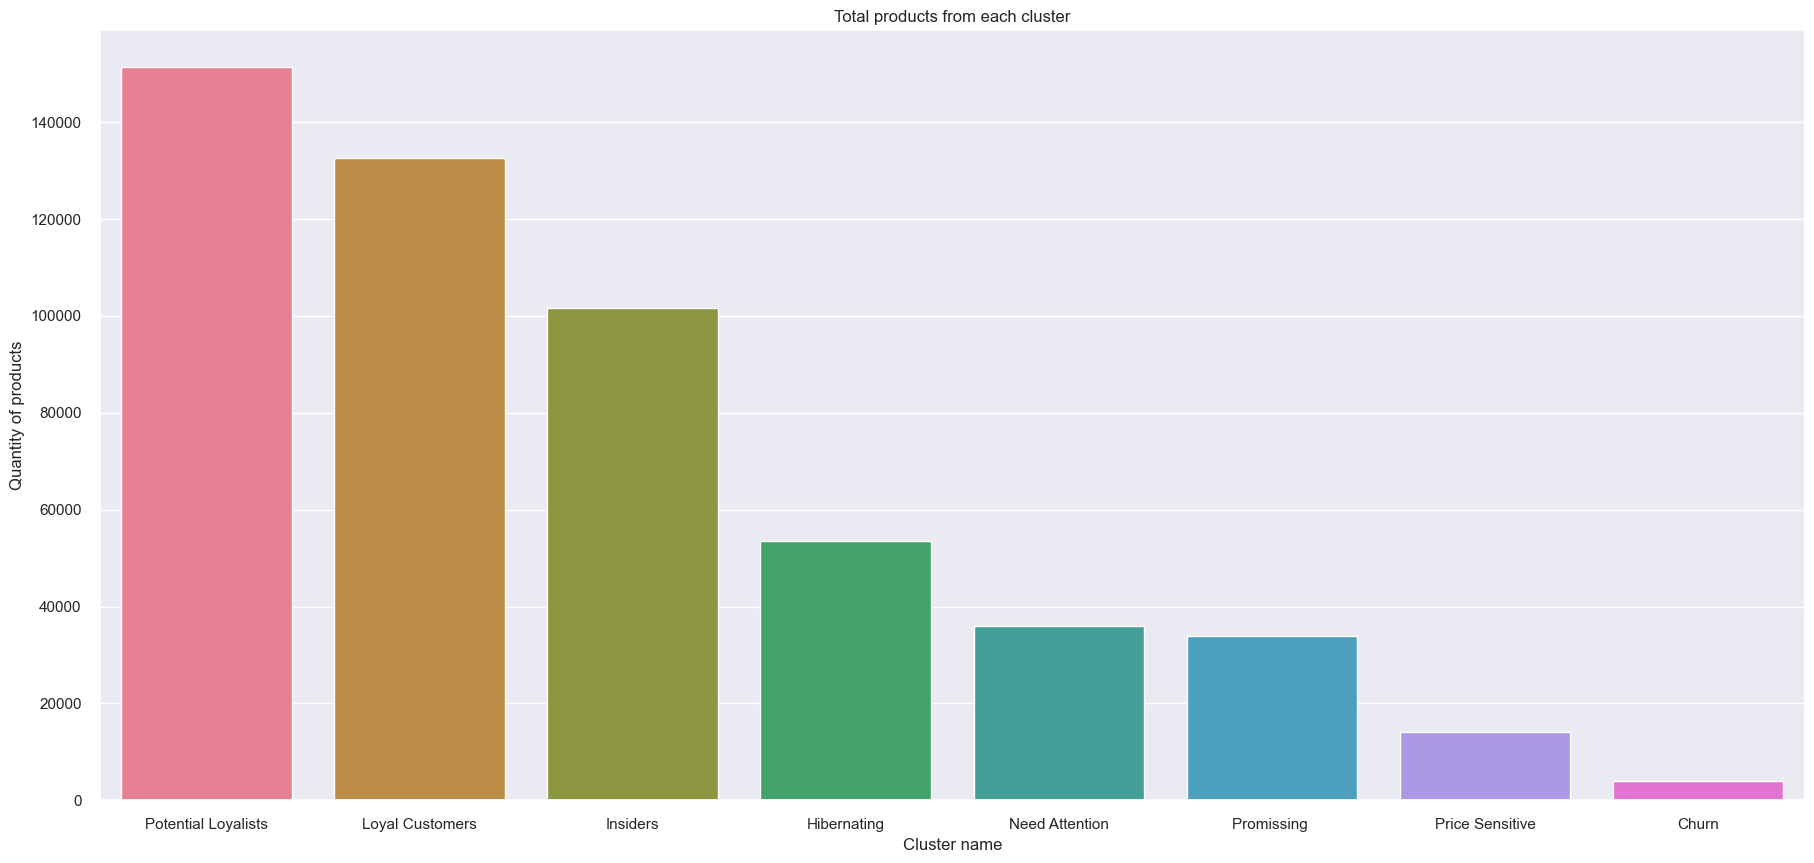

In [170]:
order = list(df11.groupby('cluster_name').sum().reset_index().sort_values('qty_products', ascending=False)['cluster_name'])

sns.barplot(x='cluster_name', y='qty_products', data=aux, palette='husl', order=order)
plt.title('Total products from each cluster')
plt.xlabel('Cluster name')
plt.ylabel('Quantity of products');

##### **H4** Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
**TRUE** Os clientes insiders correspondem a 34,54% do volume de faturamento.

In [177]:
# Total of gross revenue from each clusters
aux = df11[['cluster_name', 'gross_revenue']].groupby('cluster_name').sum().reset_index()

gr_c1 = aux.loc[2, 'gross_revenue']

gr_total = df11['gross_revenue'].sum()

print(f'Cluster insiders: {gr_c1:.2f} and total clusters: {gr_total:.2f}')
print(f' Percentage of gross revenue from Cluster Insiders: {(gr_c1 / gr_total)*100:.2f} %')

Cluster insiders: 3452587.35 and total clusters: 9996700.70
 Percentage of gross revenue from Cluster Insiders: 34.54 %


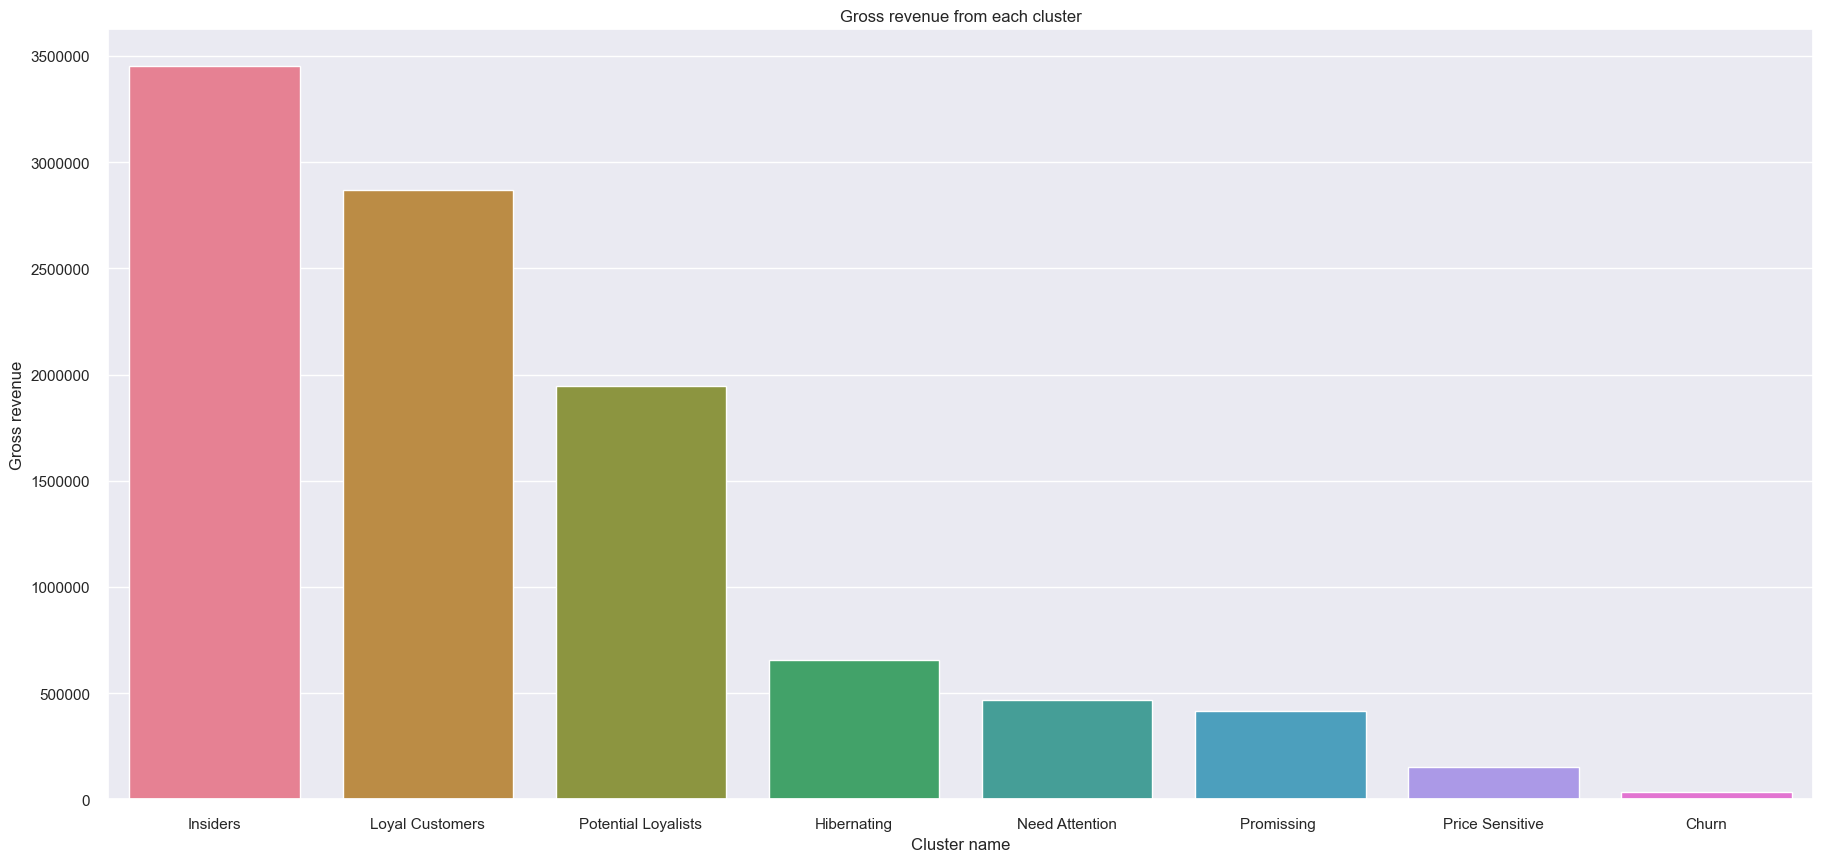

In [179]:
order = list(df11.groupby('cluster_name').sum().reset_index().sort_values('gross_revenue', ascending=False)['cluster_name'])

sns.barplot(x='cluster_name', y='gross_revenue', data=aux, palette='husl', order=order)
plt.title('Gross revenue from each cluster')
plt.xlabel('Cluster name')
plt.ylabel('Gross revenue')
plt.ticklabel_format(style='plain', axis='y');

##### **H5** A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.
**TRUE** A Mediana de faturamento dos Insiders correspondem a 423,84% da mediana de faturamento total.

In [181]:
aux = df11[['cluster_name', 'gross_revenue']].groupby('cluster_name').median().reset_index()

gr_c1 = aux.loc[2, 'gross_revenue']

gr_total = df10['gross_revenue'].median()

print(f'Cluster insiders: {gr_c1:.2f} and total clusters: {gr_total:.2f}')
print(f'The median of gross revenue from Cluster Insiders is {(gr_c1 / gr_total)*100:.2f} % more than total gross revenue')

Cluster insiders: 2607.74 and total clusters: 615.26
The median of gross revenue from Cluster Insiders is 423.84 % more than total gross revenue


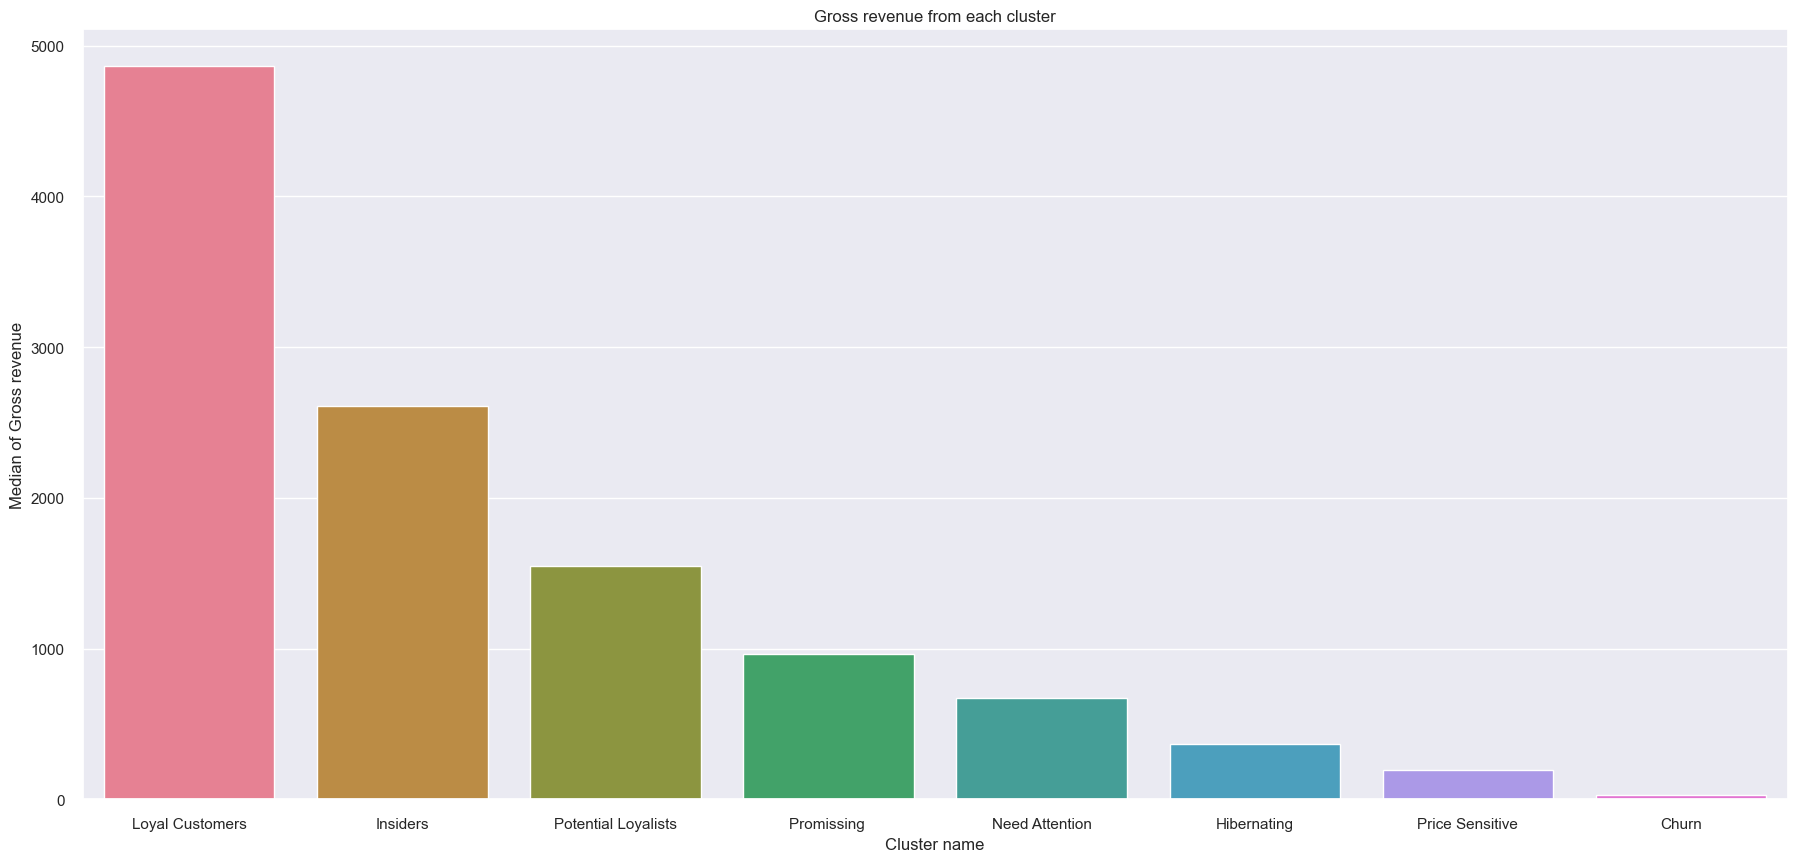

In [183]:
order = list(df11.groupby('cluster_name').median().reset_index().sort_values('gross_revenue', ascending=False)['cluster_name'])

sns.barplot(x='cluster_name', y='gross_revenue', data=aux, palette='husl', order=order)
plt.title('Gross revenue from each cluster')
plt.xlabel('Cluster name')
plt.ylabel('Median of Gross revenue');

##### **H6** A media dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a media de todos os preços dos produtos.
**TRUE** O cluster insider é em média 2,16X superior ao preço unitário do produto em comparação aos demais clusters.

In [185]:
aux = df11[['cluster_name', 'gross_revenue', 'qty_products']].groupby('cluster_name').sum().reset_index()

aux['avg_unit_price'] = aux['gross_revenue'] / aux['qty_products']

avg_c1 = aux.loc[2, 'avg_unit_price']

avg_total = aux.loc[:, 'avg_unit_price'].mean()

print(f'Cluster insiders: {avg_c1:.2f} and total clusters: {avg_total:.2f}')
print(f'Cluster Insiders is an average {(avg_c1 / avg_total)*100:.2f} % above the mean of total clusters')

Cluster insiders: 33.99 and total clusters: 15.70
Cluster Insiders is an average 216.48 % above the mean of total clusters


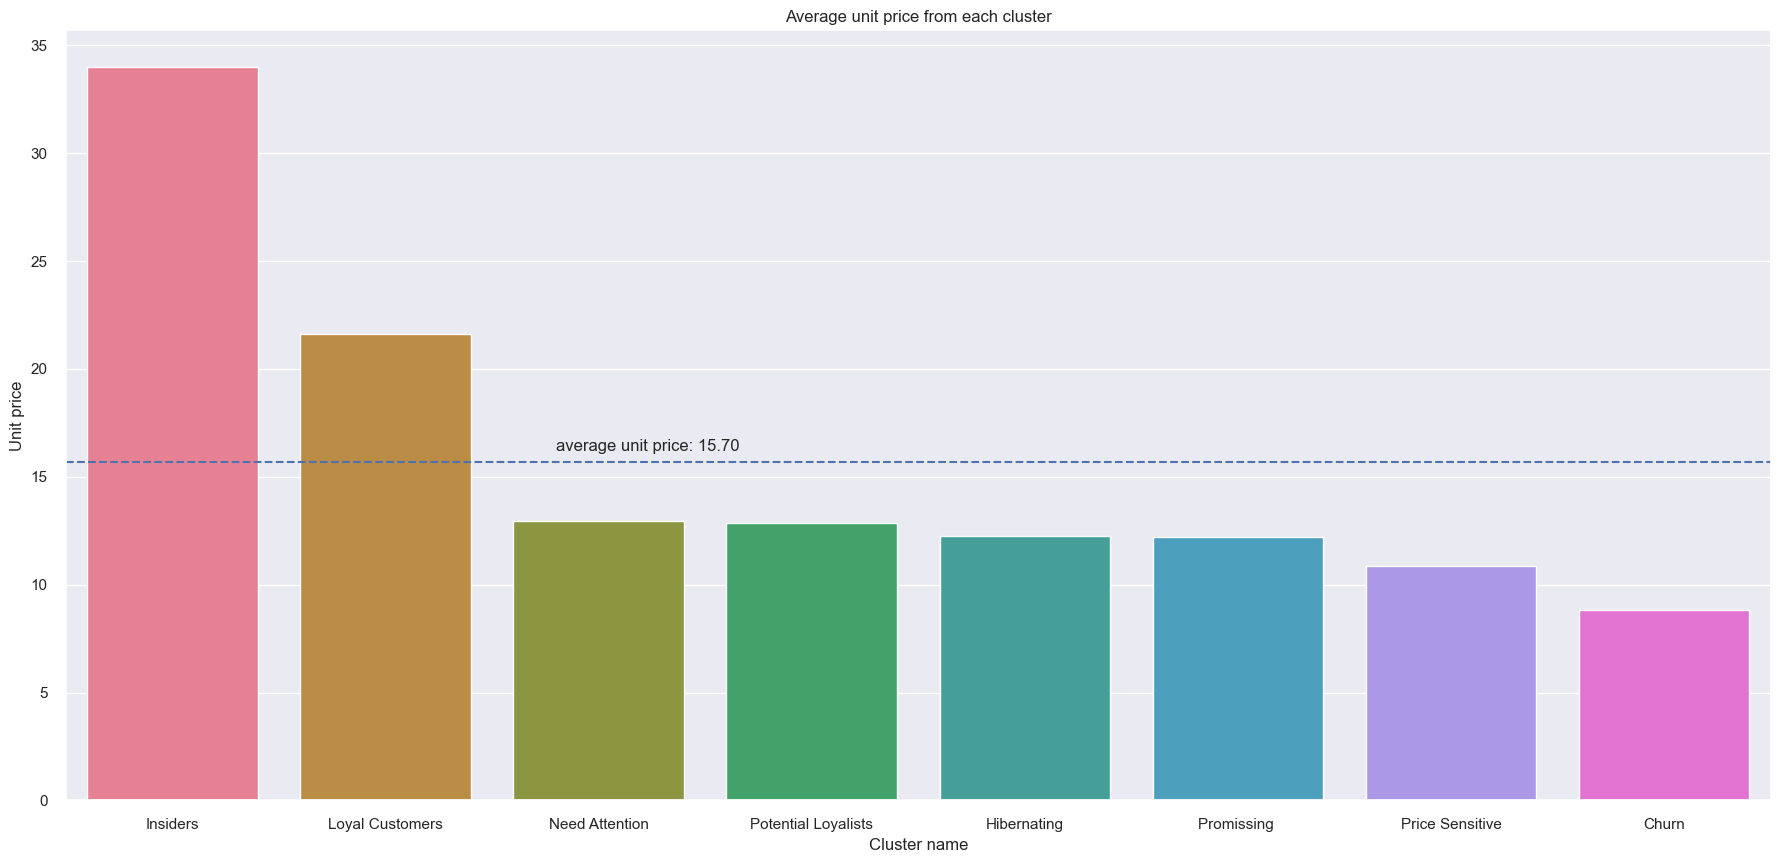

In [197]:
order = list(aux.groupby('cluster_name').mean().reset_index().sort_values('avg_unit_price', ascending=False)['cluster_name'])

sns.barplot(x='cluster_name', y='avg_unit_price', data=aux, palette='husl', order=order)
plt.title('Average unit price from each cluster')
plt.xlabel('Cluster name')
plt.ylabel('Unit price')
plt.text( 1.8,  avg_total+0.5, 'average unit price: {:.2f}'.format(avg_total)  )
plt.axhline(y = avg_total, color = 'b', linestyle = '--' );

##### **H7** Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes
**FALSE** Os clientes do cluster insiders possuem um número de devoluções 6,73X acima da média.

In [97]:
aux = df10[['cluster', 'qty_returns']].groupby('cluster').mean().reset_index()

dev_c1 = aux.loc[0, 'qty_returns']

dev_total = df10['qty_returns'].mean()

print(f'Cluster Insiders: {dev_c1:.2f} & Total of clusters: {dev_total:.2f}')
print(f'Cluster Insiders is an average {(dev_c1/dev_total)*100:.2f} % above the mean of total clusters')

Cluster Insiders: 106.88 & Total of clusters: 15.86
Cluster Insiders is an average 673.93 % above the mean of total clusters


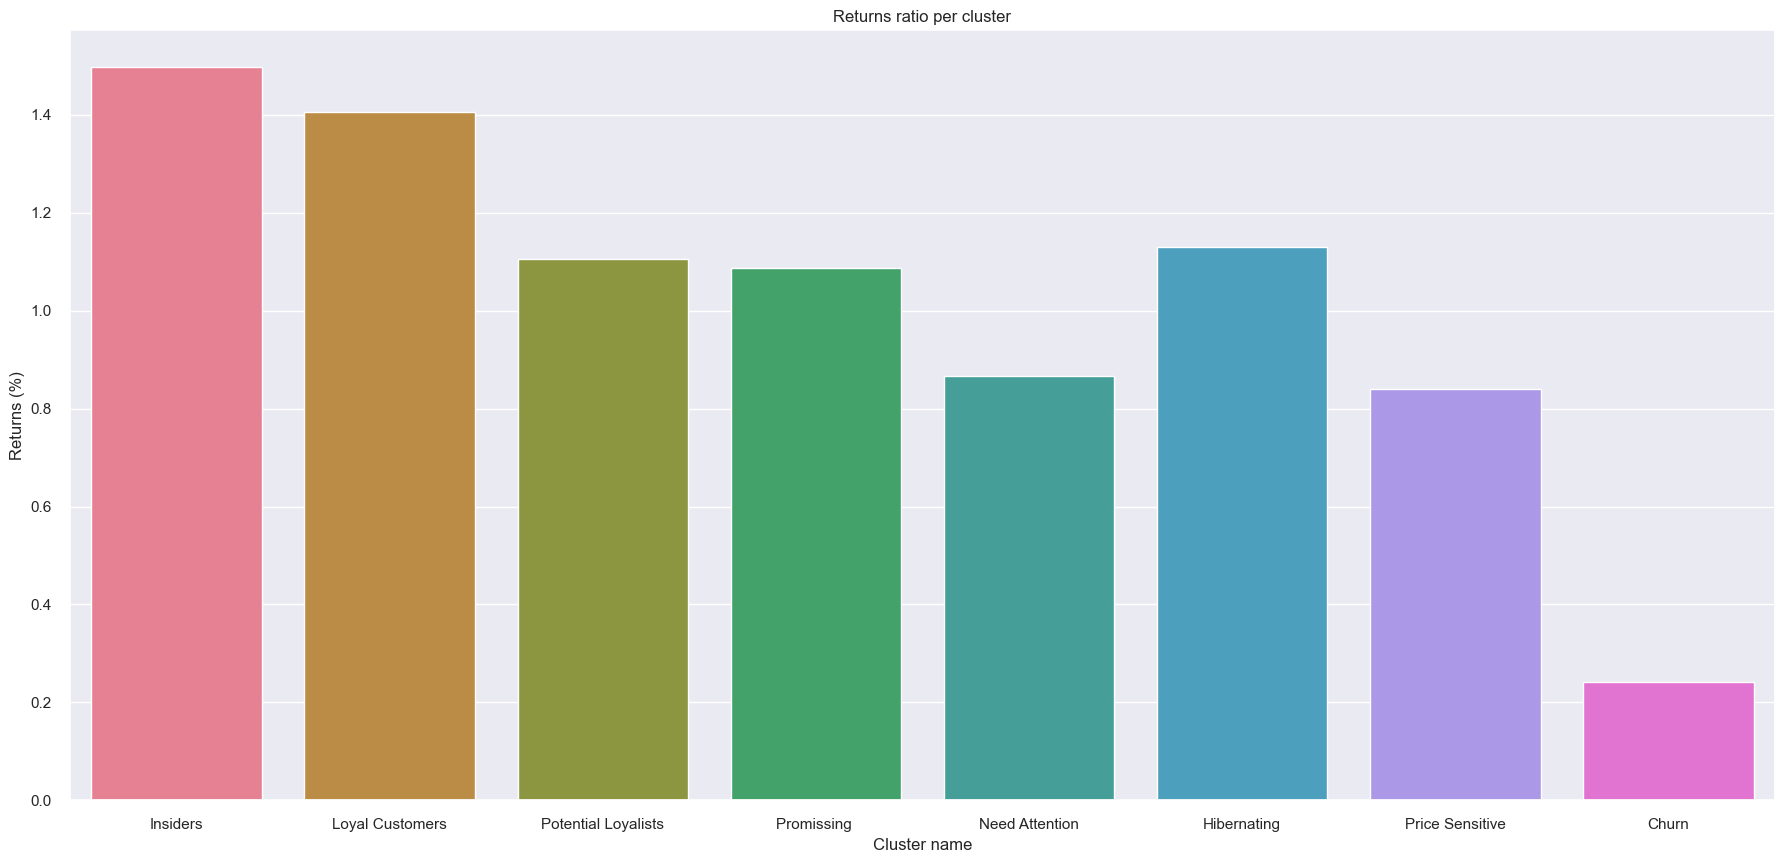

In [148]:
aux01 = df_cluster[['cluster_name', 'returns_ratio']].groupby('cluster_name').sum().reset_index()
aux01['returns_ratio'] = aux01.apply(lambda x: x['returns_ratio']*100, axis=1)

order = list(df_cluster['cluster_name'])

sns.barplot(x='cluster_name', y='returns_ratio', data=aux01, order=order, palette='husl')
plt.title('Returns ratio per cluster')
plt.xlabel('Cluster name')
plt.ylabel('Returns (%)');

## 11.4 Quadro de respostas

In [98]:
tab = [['Hipóteses', 'Conclusão'],
       ['H1', 'Verdadeira'],
       ['H2', 'Verdadeira'],
       ['H3', 'Verdadeira'],
       ['H4', 'Verdadeira'],
       ['H5', 'Verdadeira'],
       ['H6', 'Verdadeira'],
       ['H7', 'Falsa']
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão
-----------  -----------
H1           Verdadeira
H2           Verdadeira
H3           Verdadeira
H4           Verdadeira
H5           Verdadeira
H6           Verdadeira
H7           Falsa


## 11.5 Perguntas de Negócio

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo? Quais as principais características desses clientes ?
3. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
4. Qual a expectativa de faturamento desse grupo para os próximos meses ?
5. Quais as condições para uma pessoa ser elegível ao Insiders ?
6. Quais as condições para uma pessoa ser removida do Insiders ?
7. Qual a garantia que o programa Insiders é melhor que o restante da base ?
8. Quais ações o time de marketing pode realizar para aumentar o faturamento?

**Cluster Insider**

- customer_id	    416
- perc_customer	    7,324 %
- gross_revenue	    8299.489
- recency_days	    38 dias
- qty_products	    244 produtos
- frequency	        0.028 produtos/ano
- returns_ratio     0.015 %	

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [99]:
#df10[['customer_id', 'cluster']][df10['cluster'] == 1].to_csv('../data/processed/cluster_insiders.csv', index=False)

df10[['customer_id', 'cluster']][df10['cluster'] == 1]

,customer_id,cluster
0,17850,1
1,13047,1
8,15311,1
12,16029,1
15,17511,1
...,...,...
5337,12985,1
5364,14904,1
5383,22383,1
5394,12950,1


### 2. Quantos clientes farão parte do grupo? Quais as principais características desses clientes ?

In [100]:
df_cluster.head(1)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,returns_ratio,cluster_name
0,1,416,7.324,8299.489,38.005,244.173,0.028,0.015,Insiders


### 3. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [101]:
gross_total = df_cluster['gross_revenue'].sum()

gross_c1 = df_cluster['gross_revenue'][df_cluster['cluster'] == 1].values

print(f'Gross revenue for cluster insiders: {gross_c1[0]:.2f} and Gross revenue total: {gross_total:.2f}')
print(f'Cluster Insiders is: {(gross_c1 / gross_total)[0]*100:.2f} % from total')

Gross revenue for cluster insiders: 8299.49 and Gross revenue total: 18627.06
Cluster Insiders is: 44.56 % from total


### 4. Qual a expectativa de faturamento desse grupo para os próximos meses ?

- Um gráfico com previsão do faturamento
- Série de gross revenue do cluster 1 mês a mês

In [102]:
forecast_gross_df = pd.merge(df3, df10[['customer_id', 'cluster']], how='left', on='customer_id')
forecast_gross_df.dropna(inplace=True)

In [103]:
forecast_gross_df['gross_revenue'] = forecast_gross_df['unit_price'] * forecast_gross_df['quantity']
forecast_gross_df = forecast_gross_df[forecast_gross_df['cluster'] == 1]

forecast_gross_df = forecast_gross_df[['year', 'month', 'gross_revenue']].groupby(['year', 'month']).sum().reset_index()

forecast_gross_df

,year,month,gross_revenue
0,2016,11,38550.660
1,2016,12,170762.660
2,2017,1,202075.880
3,2017,2,159375.410
4,2017,3,228253.380
5,2017,4,132795.290
6,2017,5,284960.490
7,2017,6,250093.850
8,2017,7,240415.490
9,2017,8,288674.870


In [104]:
forecast_gross_df['gross_revenue']

series = pd.Series(forecast_gross_df['gross_revenue'].values)

In [105]:
series

0     38550.660
1    170762.660
2    202075.880
3    159375.410
4    228253.380
5    132795.290
6    284960.490
7    250093.850
8    240415.490
9    288674.870
10   337439.520
11   409113.960
12   519772.960
13   101391.030
dtype: float64

In [106]:
from statsmodels.tsa.arima.model import ARIMA

In [107]:
list_pred = []
for c in range(3, 15):
    arima_model = ARIMA(series[:c], order=(2,1,1))
    results = arima_model.fit()
    list_pred.append(results.forecast().values[0])

list_pred

f:\SamuelOliveiraAlvesd\Anaconda3\envs\clustering_insiders\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\SamuelOliveiraAlvesd\Anaconda3\envs\clustering_insiders\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\SamuelOliveiraAlvesd\Anaconda3\envs\clustering_insiders\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\SamuelOliveiraAlvesd\Anaconda3\envs\clustering_insiders\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

[94163.24070335043,
 90886.52924830353,
 299124.2019311541,
 198886.15432890347,
 155220.4666873449,
 320749.06925057096,
 275467.3814804743,
 299880.4786525175,
 351224.9813136548,
 418426.2100815545,
 526208.8696985033,
 337873.41707858193]

In [108]:
from numpy import sqrt
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(series[3:], list_pred[:-1]))

156474.9278696844

In [109]:
lista = []
for x in range(0, 14):
    lista.append(240262.53214285712)

In [110]:
sqrt(mean_squared_error(series, lista))

121012.44668499773

### 5. Quais as condições para uma pessoa ser elegível ao Insiders ?

In [111]:
# Variance into gross revenue via bootstrap
df_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue']

interval_gr_c1 = st.t.interval(alpha=0.95, df=len(df_insiders)-1, loc=np.mean(df_insiders), scale= st.sem(df_insiders))


# Variance into avg ticket via bootstrap
df_insiders = df10.loc[df10['cluster'] == 1, 'avg_ticket']

interval_tk_c1 = st.t.interval(alpha=0.95, df=len(df_insiders)-1, loc=np.mean(df_insiders), scale= st.sem(df_insiders))

# Variance into quantity of itens via bootstrap
df_insiders = df10.loc[df10['cluster'] == 1, 'qty_items']

interval_itens_c1 = st.t.interval(alpha=0.95, df=len(df_insiders)-1, loc=np.mean(df_insiders), scale= st.sem(df_insiders))


print(f'Range to be eligible for the insiders for gross revenue is between: {interval_gr_c1[0]:.2f} and {interval_gr_c1[1]:.2f}')
print(f'Range to be eligible for the insiders for average ticket is between: {interval_tk_c1[0]:.2f} and {interval_tk_c1[1]:.2f}')
print(f'Range to be eligible for the insiders for quantity of itens is between: {interval_itens_c1[0]:.2f} and {interval_itens_c1[1]:.2f}')

Range to be eligible for the insiders for gross revenue is between: 5817.02 and 10781.95
Range to be eligible for the insiders for average ticket is between: 36.08 and 77.98
Range to be eligible for the insiders for quantity of itens is between: 3488.43 and 6255.67


### 6. Quais as condições para uma pessoa ser removida do Insiders ?

In [112]:
print(f'The person should be removed if its value of gross revenue is less than: {interval_gr_c1[0]:.2f}')
print(f'The person should be removed if its value of average ticket is less than: {interval_tk_c1[0]:.2f}')
print(f'The person should be removed if its value of quantity of itens is less than: {interval_itens_c1[0]:.2f}')

The person should be removed if its value of gross revenue is less than: 5817.02
The person should be removed if its value of average ticket is less than: 36.08
The person should be removed if its value of quantity of itens is less than: 3488.43


### 7. Qual a garantia que o programa Insiders é melhor que o restante da base ?

Yes, all the data we have observed and the hypoteses we have tested so far indicat that these customers are indeed different from the rest of the base, since they purchase about 14x more items than the average customer and are responsible for about 40% of the revenue of the company.

### 8. Quais ações o time de marketing pode realizar para aumentar o faturamento?

In [113]:
df_cluster[['cluster', 'cluster_name', 'customer_id', 'perc_customer', 'gross_revenue', 'recency_days', 'qty_products',	'frequency', 'returns_ratio']].sort_values('gross_revenue', ascending=False)

,cluster,cluster_name,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,returns_ratio
0,1,Insiders,416,7.324,8299.489,38.005,244.173,0.028,0.015
4,5,Loyal Customers,480,8.451,5976.285,40.052,276.173,0.031,0.014
1,2,Potential Loyalists,1045,18.398,1864.094,87.016,144.840,0.009,0.011
3,4,Promissing,413,7.271,1006.377,106.910,82.354,0.007,0.011
2,3,Need Attention,647,11.391,722.785,97.291,55.730,0.007,0.009
7,8,Hibernating,1400,24.648,467.971,135.264,38.179,0.004,0.011
6,7,Price Sensitive,660,11.620,232.572,181.074,21.441,0.003,0.008
5,6,Churn,619,10.898,57.489,196.901,6.522,0.003,0.002


| Cluster | Name | Action Plan  |
|-|-|-|
| 1 | Insiders | Keep engaged, offer concierge  |
| 5 | Loyal Customers | Increase average ticket, cross-sell/upper-sell  |
| 2 | Potential Loyalists | Increase purchase frequency, more cupons  |
| 4 | Promissing | Descrease recency, more promo  |
| 3 | Need Attention | Decrease recency, more promo, cross-sell  |
| 8 | Hibernating | Make them buy again |
| 7 | Price Sensitive | Increase avg ticket, Show more promos, upper-sell |
| 6 | Churn | Make them buy again or do nothing |

## 11.6 Cohort Analysis

- Assumption: 1ª compra do customer será a primeira compra registrada no corte de tempo desse dataset

In [357]:
# Make dataframe for cohort
df_cohort = pd.merge(df3, df10[['customer_id', 'cluster']], how='left', on='customer_id')
df_cohort = df_cohort[['customer_id', 'cluster', 'quantity', 'unit_price', 'invoice_date', 'invoice_no']]
df_cohort.dropna(inplace=True)

In [358]:
# Create features for gross_revenue, first buy and cohort

df_cohort['gross_revenue'] = df_cohort['quantity'] * df_cohort['unit_price']

df_cohort['invoice_month'] = df_cohort['invoice_date'].dt.to_period('M')

df_cohort['cohort'] = df_cohort.groupby('customer_id')['invoice_date'].transform('min').dt.to_period('M')

df_cohort['period_number'] = (df_cohort['invoice_month'] - df_cohort['cohort']).apply(attrgetter('n'))

# DF for cluster insiders
df_cohort_c1 = df_cohort[df_cohort['cluster'] == 1]

# DF with all clusters
df_cohort_total = df_cohort

### 11.6.1 Cohort Insiders

In [343]:
aux = df_cohort_c1[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

(aux[aux['invoice_no'] > 1].shape[0] / aux.shape[0])*100

98.07692307692307

- 98% do Cluster de Insiders realizou mais de 1 compra

#### Cohort per unique customers

In [345]:
# join unique customers per month and check retention for each month after
df_cohort_c1 = df_cohort_c1[['customer_id', 'gross_revenue', 'cohort', 'invoice_month', 'period_number']].groupby(['cohort', 'invoice_month', 'period_number']).agg(qty_customers = ('customer_id', 'nunique'), gross_revenue = ('gross_revenue', 'sum')).reset_index()

# Create table of cohort
pivot_c1 = df_cohort_c1.pivot_table(index='cohort', columns= 'period_number', values='qty_customers')

# Highlight max values
pivot_c1.style.highlight_max(color='darkgreen', axis=0).format("{:.0f}")

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,33,28,24,20,23,22,25,21,18,20,23,22,26,15
2016-12,121,68,55,70,60,66,66,57,62,60,64,86,32,nan
2017-01,64,19,30,22,32,30,33,28,29,31,36,11,nan,nan
2017-02,36,16,14,13,16,16,16,17,18,16,6,nan,nan,nan
2017-03,48,21,30,14,26,18,26,25,26,6,nan,nan,nan,nan
2017-04,28,15,14,8,13,11,18,13,3,nan,nan,nan,nan,nan
2017-05,25,12,8,14,11,12,15,4,nan,nan,nan,nan,nan,nan
2017-06,12,4,4,6,7,8,3,nan,nan,nan,nan,nan,nan,nan
2017-07,10,3,2,6,5,4,nan,nan,nan,nan,nan,nan,nan,nan


#### Cohort per gross revenue

In [346]:
# Create table of cohort
pivot_c1 = df_cohort_c1.pivot_table(index='cohort', columns= 'period_number', values='gross_revenue')

# Highlight max values
pivot_c1.style.highlight_max(color='darkgreen', axis=0).format("{:.0f}")

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,38551,52737,59431,36312,56955,29905,61217,57485,71232,63126,81735,78458,99750,27934
2016-12,118025,96172,79321,106479,56219,135863,120991,101586,149126,182196,189282,163306,44098,nan
2017-01,46473,20325,28650,7696,39186,36252,27164,39896,14253,55096,39123,5072,nan,nan
2017-02,23417,8273,10195,7010,6067,7453,9100,9993,13357,14352,207,nan,nan,nan
2017-03,27895,7255,15083,6383,14296,6717,13166,15451,14753,1376,nan,nan,nan,nan
2017-04,21526,10816,6881,2949,7150,5307,11361,8695,1004,nan,nan,nan,nan,nan
2017-05,15785,5446,4999,4423,5628,6250,12665,1651,nan,nan,nan,nan,nan,nan
2017-06,10589,1352,1625,3775,4924,6216,1162,nan,nan,nan,nan,nan,nan,nan
2017-07,9384,1691,908,2758,4149,1205,nan,nan,nan,nan,nan,nan,nan,nan


### 11.6.2 Cohort total customers

In [359]:
aux = df_cohort_total[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

(aux[aux['invoice_no'] > 1].shape[0] / aux.shape[0])*100

53.010563380281695

- 53% dos Clusters realizaram mais de 1 compra

#### Cohort per unique customers

In [361]:
# join unique customers per month and check retention for each month after
df_cohort_total = df_cohort_total[['customer_id', 'gross_revenue', 'cohort', 'invoice_month', 'period_number']].groupby(['cohort', 'invoice_month', 'period_number']).agg(qty_customers = ('customer_id', 'nunique'), gross_revenue = ('gross_revenue', 'sum')).reset_index()

# Create table of cohort
pivot_total = df_cohort_total.pivot_table(index='cohort', columns= 'period_number', values='qty_customers')

# Highlight max values
pivot_total.style.highlight_max(color='darkgreen', axis=0).format("{:.0f}")

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,209,91,78,68,75,76,80,79,71,74,79,78,97,38
2016-12,873,296,236,290,251,298,265,263,262,281,297,388,160,nan
2017-01,578,109,130,112,157,134,127,126,141,158,177,45,nan,nan
2017-02,459,90,66,103,99,86,85,100,99,110,24,nan,nan,nan
2017-03,541,77,110,83,103,78,102,107,113,32,nan,nan,nan,nan
2017-04,373,65,60,61,57,66,66,78,17,nan,nan,nan,nan,nan
2017-05,426,66,49,49,62,72,84,15,nan,nan,nan,nan,nan,nan
2017-06,351,50,43,58,60,72,14,nan,nan,nan,nan,nan,nan,nan
2017-07,326,44,40,47,55,19,nan,nan,nan,nan,nan,nan,nan,nan


#### Cohort per gross revenue

In [362]:
# Create table of cohort
pivot_total = df_cohort_total.pivot_table(index='cohort', columns= 'period_number', values='gross_revenue')

# Highlight max values
pivot_total.style.highlight_max(color='darkgreen', axis=0).format("{:.0f}")

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,104674,89741,87800,59822,80916,49646,90204,82157,95655,88634,115185,117393,158859,43426
2016-12,570150,204664,164705,213094,143068,253780,217036,211707,258457,314536,344230,360146,95489,nan
2017-01,314272,56786,65413,48931,97143,78517,76711,86380,75659,118352,132526,20980,nan,nan
2017-02,213761,25348,30513,43873,32035,32309,38565,49597,46495,56017,4731,nan,nan,nan
2017-03,278282,23219,57654,35839,49776,42279,54461,64466,59511,7612,nan,nan,nan,nan
2017-04,193646,24806,21833,19944,21192,26011,27659,31442,3995,nan,nan,nan,nan,nan
2017-05,208632,17854,19690,16983,27587,34109,37447,5038,nan,nan,nan,nan,nan,nan
2017-06,202493,14317,12271,27617,25648,36761,4214,nan,nan,nan,nan,nan,nan,nan
2017-07,190421,10581,16321,18925,20410,4755,nan,nan,nan,nan,nan,nan,nan,nan


# 12.0 Deploy model to production